











Checklist
1. Make sure your "Regional Format" is set to "English (United Kingdom)" before Excel opens files that contain English date-like objects,
   if you want them to be parsed as English datetime. English (United States) regional format will convert them to American Datetime as possible.
   You have no way to prevent Excel from converting date-like strings or objects to datetime when opening a file. 

In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import datetime
import re
import os
import glob
import math
import gc

from config import config
import YH_assistant

In [2]:
TRAIN_MODE = True
OPERATION = 'BACKTEST'  # 'PRETRAIN'  'TRAIN_C'   'FINETUNE'   'TEST', 'BACKTEST'

TEST_ID = 'YH.02'
HISTORY_LEN = 400
SEQ_YEAR_SPAN = 15
NOTE = 'Test'

DATA_THEME = str(HISTORY_LEN).zfill(3) + '-' + str(SEQ_YEAR_SPAN).zfill(2) + '-' + NOTE
COPY_IDS_DS_DATA_FROM = None  # "_THEME_400-15-FillNan"

STARTING_PERCENT = 0
ENDING_PERCENT = 0
TRAIN_PERCENT= 96
VALID_PERCENT = 4
TEST_PERCENT = 100 - TRAIN_PERCENT - VALID_PERCENT

BATCH_SIZE = 30 # 25 for headers 6.

TEAM_EMBS = 50  #
DECODE_BASE_DATE = False
EMBED_AB_COLS = False    # True: Pls choose a small LR so that we have plenty of train epochs and the embedded values have enough chance to seek their proper places.
ODDS_IN_ENCODER = False   #--------------
ODDS_IN_DECODER = True
ADDITIONAL_D_MODEL = 0   #------------ Try increase it when underfitting.

TRANSFORMER_LAYERS = 30
TRANSFORMER_HEADS = 5 #-------------- 6
BALANCE_POS_CODE = True        # True: Weakens positional code compared to embedded values.
DROPOUT = 0.0  # 0.1
ADAPTORS_LAYERS = 0 #------------ 10
ADAPTORS_WIDTH_FACTOR = 30  # 30

# This is an exponential curve that hits STARTING_LEARNING_RATE at step zero and EXAMPLE_LEARNING_RATE at step EXAMPLE_LEARNING_STEP.
# lr(step) = STARTING_LEARNING_RATE * pow( pow(EXAMPLE_LEARNING_RATE/STARTING_LEARNING_RATE, 1/EXAMPLE_LEARNING_STEP), step )
STARTING_LEARNING_RATE = 5e-7
EXAMPLE_LEARNING_RATE = STARTING_LEARNING_RATE * 0.5    #------------ 0.5 worked.
EXAMPLE_LEARNING_STEP = 100

MODEL_ACTIVATION = 'softmax'    # 'softmax', 'sigmoid', 'relu', 'open'
LOSS_TYPE = 'profit'           # 'profit', 'entropy'
VECTOR_BETTING = False
MODEL_TYPE_CHECK = False
GET_VAL_LOSS_0 = False
IGNORE_HISTORY = False
SIMPLIFY_ADAPTOR = True
NUMBER_QUERIES = 3

In [3]:
COUNTRY = 'England'
NUMBER_BOOKIES = 5  # Take William Hills, Bet&Win, and Bet365. Other bookies' odds list change over years and leagues.
PREFERED_ORDER = ['B365', 'WH']   # Implies the order only.
BOOKIE_TO_EXCLUDE = []    # 'BWIN' odds don't show up since mid Febrary 2025. This may reduce the effective NUMBER_BOOKIES.
DIVIISONS = ['E0', 'E1', 'E2', 'E3']    # 'EC', the Conference league, is excluded as some odds makers are not archived for the league since 2013.
REPEATING_BOOKIE = None    #-----------------------------------

"""
#-------------------- England ---------------------
Time range of data: 2004/2005 - 2024/2025
Leagues - Premiere, League 1, League 2, Championship, Conference (dropped out)
!!! Conference will be dropped out because they lack Shoot_cols and ShootT_cols since 2026. Those columns are important.
Bookies - Bookie1 : WH(William Hills), Bookie2: BW(Bet&Win), Bookie3 : B365(Bet365), Bookie4 : Mixed
William Hills, Bet365 on Premier: https://www.oddschecker.com/football/english/premier-league
William Hills, Bet365 on Championship: https://www.oddschecker.com/football/english/championship
William Hills, Bet365 on League-1: https://www.oddschecker.com/football/english/league-1
William Hills, Bet365 on League-2: https://www.oddschecker.com/football/english/league-2
William Hills, Bet365 on Conference: https://www.oddschecker.com/football/english/non-league/national-league
BWin(Bet&Win) on Premier and Chanpionship: https://sports.bwin.fr/fr/sports/football-4/paris-sportifs/angleterre-14
"""

# COUNTRY = 'Scotland'
# NUMBER_BOOKIES = 3  # Take ...

'\n#-------------------- England ---------------------\nTime range of data: 2004/2005 - 2024/2025\nLeagues - Premiere, League 1, League 2, Championship, Conference (dropped out)\n!!! Conference will be dropped out because they lack Shoot_cols and ShootT_cols since 2026. Those columns are important.\nBookies - Bookie1 : WH(William Hills), Bookie2: BW(Bet&Win), Bookie3 : B365(Bet365), Bookie4 : Mixed\nWilliam Hills, Bet365 on Premier: https://www.oddschecker.com/football/english/premier-league\nWilliam Hills, Bet365 on Championship: https://www.oddschecker.com/football/english/championship\nWilliam Hills, Bet365 on League-1: https://www.oddschecker.com/football/english/league-1\nWilliam Hills, Bet365 on League-2: https://www.oddschecker.com/football/english/league-2\nWilliam Hills, Bet365 on Conference: https://www.oddschecker.com/football/english/non-league/national-league\nBWin(Bet&Win) on Premier and Chanpionship: https://sports.bwin.fr/fr/sports/football-4/paris-sportifs/angleterre-1

In [4]:
def set_seed(seed): np.random.seed(seed); tf.random.set_seed(seed); random.seed(seed)
set_seed(23)    # For serendipity

In [5]:
ODDS_COLS = []
for b in range(NUMBER_BOOKIES):
    ODDS_COLS += ['HDA'+str(b)+'H', 'HDA'+str(b)+'D', 'HDA'+str(b)+'A']

In [6]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ODDS_COLS
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols
Required_Non_Odds_cols = Div_cols + Date_cols + Team_cols + Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols

# underscore_prefixed lists have discontinued columns.
BBAB_cols = BB_cols + AB_cols

# Make sure Odds_cols comes first !!!
_Cols_to_Always_Normalize = Odds_cols

_Label_cols = Full_Goal_cols + Odds_cols

bbab_odds_start = BBAB_cols.index(Odds_cols[0])
bb_odds_start = BB_cols.index(Odds_cols[0])
label_odds_start = _Label_cols.index(Odds_cols[0])

In [7]:
print(BBAB_cols)
print(BB_cols)
print(_Label_cols)

['id', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A', 'HDA2H', 'HDA2D', 'HDA2A', 'HDA3H', 'HDA3D', 'HDA3A', 'HDA4H', 'HDA4D', 'HDA4A', 'HTHG', 'HTAG', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY']
['id', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A', 'HDA2H', 'HDA2D', 'HDA2A', 'HDA3H', 'HDA3D', 'HDA3A', 'HDA4H', 'HDA4D', 'HDA4A']
['FTHG', 'FTAG', 'HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A', 'HDA2H', 'HDA2D', 'HDA2A', 'HDA3H', 'HDA3D', 'HDA3A', 'HDA4H', 'HDA4D', 'HDA4A']


In [ ]:
country_folder = "./data/football-data-co-uk/" + COUNTRY
gameHistory_folder_path = os.path.join(country_folder, 'Game_History')
if not os.path.exists(gameHistory_folder_path): os.makedirs(gameHistory_folder_path, exist_ok=False)
countryTheme_folder_path = os.path.join(country_folder, '_DATA_' + DATA_THEME)
if not os.path.exists(countryTheme_folder_path): os.makedirs(countryTheme_folder_path, exist_ok=False)
map_folder_path = os.path.join(countryTheme_folder_path, '_id_map')     # do not change to '_map' for backward compatibility
if not os.path.exists(map_folder_path): os.makedirs(map_folder_path, exist_ok=False)
dataset_foler_path = os.path.join(countryTheme_folder_path, '_dataaset')    # keep '_dataaset' as it for backward compatibility
if not os.path.exists(dataset_foler_path): os.makedirs(dataset_foler_path, exist_ok=False)
checkpoint_folder_path = os.path.join(country_folder, '_checkpoints')
if not os.path.exists(checkpoint_folder_path): os.makedirs(checkpoint_folder_path, exist_ok=False)
tokenizer_folder_path =  os.path.join(countryTheme_folder_path, '_tokenizer')
if not os.path.exists(tokenizer_folder_path): os.makedirs(tokenizer_folder_path, exist_ok=False)
map_filename_base = DATA_THEME
dataset_path = os.path.join(dataset_foler_path, map_filename_base + '-foundation-ds')

In [9]:
YH_assistant.assign_seasonal_filenames(gameHistory_folder_path)
df_train, df_new = YH_assistant.get_train_and_new_from_football_data_v2(gameHistory_folder_path, countryTheme_folder_path, Required_Non_Odds_cols, NUMBER_BOOKIES, oddsGroupsToExclude = BOOKIE_TO_EXCLUDE, preferedOrder = PREFERED_ORDER, train_mode = TRAIN_MODE, skip=True)
print("df_train: ", df_train.shape)
print("df_new: ", df_new.shape)

files found to rename:  0
total rows in renamed files:  0
df_train:  (42209, 38)
df_new:  (0, 38)


In [10]:
tokenizer_team = YH_assistant.creat_team_tokenizer_uk(df_train, tokenizer_folder_path)
team_vocab = list(tokenizer_team.get_vocab().keys())

print(tokenizer_team.get_vocab_size())
print(tokenizer_team.get_vocab())
print(team_vocab)

teams = ['Tottenham', 'Arsenal', 'Liverpool', 'what?', 'Tottenham', 'Chelsea', 'e_t', 'Man United', '1234', '[HOME]', '[AWAY]']
teams = [team.strip() for team in [re.sub(r"\s", "_", item) for item in teams]]
teams = " ".join(teams)
encoding = tokenizer_team.encode(teams)
# encoding = tokenizer.encode("")
print(encoding.tokens)
print(encoding.type_ids)
print(encoding.ids)
print(tokenizer_team.decode(encoding.ids))
teams, success = YH_assistant.convert_to_token(tokenizer_team, ['Manchester United', 'Man united', 'man_united', 'chelsea'])
print(teams)

similars = YH_assistant.find_most_similar_teams(team_vocab, 'manchester united', 3)
print(similars)

teams, candidates, success = YH_assistant.convert_to_token_with_candidates(tokenizer_team, ['mman United', 'Liberpool', 'chelsea'], candi_count=3)
print(candidates)


114
{'dag_and_red': 37, 'crystal_palace': 36, 'york': 113, 'crewe': 35, 'west_brom': 106, 'kidderminster': 54, 'brighton': 17, 'norwich': 72, 'watford': 105, 'peterboro': 77, 'sutton': 98, 'darlington': 38, 'charlton': 27, 'forest_green': 44, 'harrogate': 48, 'shrewsbury': 91, 'bolton': 12, 'gillingham': 46, 'afc_wimbledon': 2, 'tottenham': 102, 'wrexham': 110, 'oldham': 75, 'huddersfield': 51, 'mansfield': 64, 'stockport': 95, 'portsmouth': 80, 'sheffield_united': 89, 'crawley_town': 34, 'aldershot': 3, 'burnley': 21, 'colchester': 32, 'cheltenham': 29, 'macclesfield': 61, 'salford': 87, 'walsall': 104, 'swansea': 99, 'morecambe': 68, 'blackpool': 11, 'chester': 30, 'southend': 93, 'preston': 81, 'boston': 13, 'notts_county': 74, 'aston_villa': 5, 'burton': 22, 'everton': 41, 'exeter': 42, 'man_united': 63, 'scunthorpe': 88, 'leeds': 55, 'torquay': 101, 'cardiff': 25, 'yeovil': 112, 'chesterfield': 31, 'liverpool': 59, 'lincoln': 58, 'leyton_orient': 57, 'chelsea': 28, "nott'm_forest"

In [11]:
if COPY_IDS_DS_DATA_FROM is not None:
    YH_assistant.remove_folder_contents(map_folder_path)
    source_map_folder_path = os.path.join(country_folder, COPY_IDS_DS_DATA_FROM, '_id_map')
    YH_assistant.copy_id_map(source_map_folder_path, map_folder_path, NOTE)

In [12]:
#================= build_id_to_ids.ipynb

targetLength = HISTORY_LEN          # A target game will be explained by maximum 'targetLength' count of past games.
id_map_filePath = os.path.join(map_folder_path, map_filename_base + ".json")

# if TRAIN_MODE: df_total = df_train; df_search = df_train
# else: df_total = df_train; df_search = df_new

df_sequence = df_train; df_base = df_train   # Think of TRAIN_MODE==True only.
train_map = YH_assistant.create_map_v1(map_folder_path, map_filename_base, targetLength, df_sequence, df_base, year_span=SEQ_YEAR_SPAN, testcount=-1)
YH_assistant.SaveJsonData(train_map, id_map_filePath)

print(len(train_map))

42209


In [13]:
# lengths = [len(ids) for (report, ids) in train_map.values()]
# maxLen = max(lengths)
# plt.hist(lengths, np.linspace(0, int(maxLen*1.1), int(maxLen*1.1) + 1))
# plt.ylim(plt.ylim())
# maxLen = max(lengths)
# # plt.plot([maxLen, maxLen], plt.ylim())
# plt.title(f'Max length of ids: {maxLen}')

# lengths = [len(ids) for (report, ids) in train_map.values()]
# maxLen = max(lengths)
# plt.hist(lengths, np.linspace(0, int(maxLen*0.9), int(maxLen*0.9) + 1))
# plt.ylim(plt.ylim())
# maxLen = max(lengths)
# # plt.plot([maxLen, maxLen], plt.ylim())
# plt.title(f'Max length of ids: {maxLen}')
# assert maxLen == HISTORY_LEN

MAX_TOKENS = HISTORY_LEN

In [14]:
def standardize_raw_bbab(bbab, tokenizer_team, normalization_parms):

    label = []
    #---------------------- label, before changing bbab. They are raw full-time goals and raw odds.
    for col in _Label_cols:
        start = BBAB_cols.index(col)
        label.append(bbab[start])

    #----------------------- 
    start = BBAB_cols.index(Div_cols[0])
    Div = bbab[start]
    bbab[start] = DIVIISONS.index(Div)  # Assumes no n/a

    start = BBAB_cols.index(Team_cols[0]); end = BBAB_cols.index(Team_cols[-1]) + 1
    pair_str = [str(team) for team in bbab[start : end]]    # Team names are already normalized, removing/striping spaces.
    pair_text = " ".join(pair_str)
    pair_tokens = tokenizer_team.encode(pair_text).ids
    bbab[start : end] = pair_tokens # 0 for Unknown, by tokenizer trainig.

    #--------------------- normalize
    for col in _Cols_to_Always_Normalize:   # Odds_cols only now.
        (mean, std, maximum) = normalization_parms[col]
        start = BBAB_cols.index(col)
        bbab[start] = (bbab[start] - mean) / std

    #--------------------- columns for positional embedding
    start = BBAB_cols.index(Date_cols[0])   #
    date = bbab[start]
    bbab[start] = (datetime.datetime.combine(date, datetime.time(0,0,0)) - config['baseDate']).days  # either positive or negative

    #---------------------- bb only
    start = BBAB_cols.index(BB_cols[0]); end = start + len(BB_cols)     # 
    bb = bbab[start : end]

    return bbab, bb, label, date

def getDateDetails(date):
    baseYear = config['baseDate'].year
    date_details = tf.Variable([date.year - baseYear, date.month, date.day, date.weekday()], dtype=tf.int32, trainable=False)
    return date_details     # (4,)

filler = tf.zeros_like([0] * len(BBAB_cols), dtype=tf.float32)

def get_data_record(df_sequence, df_base, baseId, ids, tokenizer_team, normalization_parms):
    # try:
        # base_bbab = list(df_train.loc[df_train['id'] == baseId, BBAB_cols])
        base_bbab = list(df_sequence[df_base['id'] == baseId][BBAB_cols].iloc[0, :])  # base_bbab follows BBAB. list------
        base_bbab, base_bb, base_label, base_date = standardize_raw_bbab(base_bbab, tokenizer_team, normalization_parms, dummy_base_ab=dummy_base_ab)
        # base_bbab, base_bb, base_label, base_date
        baseId = tf.Variable(baseId, dtype=tf.int32, trainable=False)
        base_bbab = tf.Variable(base_bbab, dtype=tf.float32, trainable=False)    # (len(BBAB_cols),)
        base_bb = tf.Variable(base_bb, dtype=tf.float32, trainable=False)        # (len(BB_cols),)
        base_label = tf.Variable(base_label, dtype=tf.float32, trainable=False)  # (len(_Label_cols),)
        # print('3', base_bbab)
        # Default sequence.
        sequence = tf.transpose(tf.Variable([[]] * len(BBAB_cols), dtype=tf.float32, trainable=False))   # (0, len(BBAB_cols))
        # sequence = np.array([[]] * len(BBAB_cols), dtype=config['np_float']).T
        # print('3.5', sequence)
        baseDateDetails = getDateDetails(base_date) # (4,)

        concat = []
        for id in ids:
            bbab = list(df_sequence[df_sequence['id'] == id][BBAB_cols].iloc[0, :])   # bbab follows BBAB. list
            bbab, _, _, _ = standardize_raw_bbab(bbab, tokenizer_team, normalization_parms)   # bbab follows BBAB. list
            # check_normalization(bbab, normalization_parms)

            bbab = tf.Variable(bbab, dtype=tf.float32, trainable=False)[tf.newaxis, :]       # (1, len(BBAB_cols))
            # _bbab = bbab[0].numpy()
            # check_normalization(_bbab, normalization_parms)

            concat.append(bbab)     # concat doesn't create a new axis.

        if len(concat) > 0:
            sequence = tf.concat(concat, axis=0)    # (nSequence, len(BBAB_cols))
            # if sequence.shape[0] > 0:
            #     bbab = sequence[0].numpy()
            #     check_normalization(bbab, normalization_parms)

        seq_len_org = sequence.shape[0]
        nMissings = MAX_TOKENS - seq_len_org
        if nMissings > 0:
            patch = tf.stack([filler] * nMissings, axis=0)
            sequence = tf.concat([sequence, patch], axis=0)     # concat doesn't create a new axis. (MAX_TOKENS, len(BBAB_cols))
        base_bb = base_bb[tf.newaxis, :]    # shape: (seq_len = 1, len(BBAB_cols))
        baseDateDetails = baseDateDetails[tf.newaxis, :]
        mask = tf.Variable([1] * seq_len_org + [0] * nMissings, dtype=tf.int32, trainable=False) # (MAX_TOKENS,) ## DO NOT USE tf.constant !!! unstable.
        mask = mask[:, tf.newaxis] & mask[tf.newaxis, :]    # (MAX_TOKENS, MAX_TOKENS)

        return (baseId, sequence, base_bb, base_label, baseDateDetails, mask)


def create_dataset(df_sequence, df_base, existing_ds, total_map, tokenizer_team, normalization_parms):
    def generator():
        total_baseIds = [int(id) for id in list(total_map.keys())]
        max_id = -1; count = 0
        if existing_ds is not None and len(existing_ds) > 0:
            for z in existing_ds:
                (baseId, sequence, base_bb, base_label, baseDateDetails, mask) = z
                baseId = baseId.numpy()
                if baseId in total_baseIds:
                    if max_id < baseId: max_id = baseId
                    print("count: {}, baseId: {}".format(count, baseId), end='\r'); count += 1
                    yield z
 
        new_map = { id : value for (id, value) in total_map.items() if max_id < int(id)}

        for baseId, (report, ids) in new_map.items():
            baseId = int(baseId)
            baseId, sequence, base_bb, base_label, baseDateDetails, mask = get_data_record(df_sequence, df_base, baseId, ids, tokenizer_team, normalization_parms)
            print("count: {}, baseId: {}".format(count, baseId), end='\r'); count += 1
            # if count > 200: break
            yield (baseId, sequence, base_bb, base_label, baseDateDetails, mask)

    ds = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.int32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32),
        output_shapes=(tf.TensorShape(()), tf.TensorShape((MAX_TOKENS, len(BBAB_cols))), tf.TensorShape((1, len(BB_cols),)), tf.TensorShape((len(_Label_cols),)), tf.TensorShape((1, 4)), tf.TensorShape((MAX_TOKENS, MAX_TOKENS))),
        args=()
    )
    return ds

def repeat_odds(sequence, base_bb, base_label, repeating_bookie):
    # sequence: (batch, max_seq_len, bbab_cols)
    # base_bb:  (batch, 1, bb_cols)
    # base_label: (batch, _Label_cols)
    def repeat_odds3(tensor, oddsStart):
        seedStart = oddsStart + repeating_bookie * NUMBER_QUERIES
        seedEnd = seedStart + NUMBER_QUERIES
        oddsSeed = tensor[:, :, seedStart : seedEnd]
        odds = tf.concat([oddsSeed] * NUMBER_BOOKIES, axis=-1)
        tensor = tf.concat( [tensor[:, :, : oddsStart], odds, tensor[:, :, oddsStart + NUMBER_BOOKIES * NUMBER_QUERIES :] ], axis=-1)
        return tensor
    
    def repeat_odds2(tensor, oddsStart):
        seedStart = oddsStart + repeating_bookie * NUMBER_QUERIES
        seedEnd = seedStart + NUMBER_QUERIES
        oddsSeed = tensor[:, seedStart : seedEnd]
        odds = tf.concat([oddsSeed] * NUMBER_BOOKIES, axis=-1)
        tensor = tf.concat( [tensor[:, : oddsStart], odds, tensor[:, oddsStart + NUMBER_BOOKIES * NUMBER_QUERIES :] ], axis=-1)
        return tensor

    sequence = repeat_odds3(sequence, bbab_odds_start)
    base_bb = repeat_odds3(base_bb, bb_odds_start)
    base_label = repeat_odds2(base_label, label_odds_start)

    return sequence, base_bb, base_label

   
def X_versus_Y(baseId, sequence, base_bb, base_label, baseDateDetails, mask):
    if REPEATING_BOOKIE is not None:
        sequence, base_bb, base_label = repeat_odds(sequence, base_bb, base_label, REPEATING_BOOKIE)
    return (baseId, sequence, base_bb, baseDateDetails, mask), (base_label)

# I found, in PositionalEmbedding, batch size ranges between 3, 4, 6 and 8, while they should be 4 or 8, except margial rows. Check it.
train_batch_size = BATCH_SIZE
test_batch_size = BATCH_SIZE * 2

def apply_train_pipeline(ds):
    return (
        ds
        .shuffle(ds.cardinality(), reshuffle_each_iteration=True)       # reshuffle doesn't happen at python iteration(ds)
        .batch(train_batch_size)
        .map(X_versus_Y, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

def apply_test_pipeline(ds):
    return (
        ds
        .batch(test_batch_size)
        .map(X_versus_Y, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

In [15]:
if COPY_IDS_DS_DATA_FROM is not None:
    YH_assistant.remove_folder_contents(dataset_foler_path)
    source_map_folder_path = os.path.join(country_folder, COPY_IDS_DS_DATA_FROM, '_dataaset')
    YH_assistant.copy_dataset(source_map_folder_path, dataset_foler_path, NOTE)

In [16]:
std_path = os.path.join(dataset_foler_path, map_filename_base + '-normalization' + ".json")
normalization_parms = YH_assistant.get_normalization_params(df_train, cols = _Cols_to_Always_Normalize + AB_cols)
print(normalization_parms)
YH_assistant.SaveJsonData(normalization_parms, std_path)
normalization_parms = YH_assistant.LoadJsonData(std_path)

{'HDA0H': (2.5345052003127293, 2.2318611079843627, 46.0), 'HDA0D': (3.613790423843256, 0.7060445822477023, 17.0), 'HDA0A': (3.806163140562439, 2.228948448158605, 41.0), 'HDA1H': (2.497184249804544, 2.2118145053553517, 46.0), 'HDA1D': (3.577757824160724, 0.7711077176624471, 13.0), 'HDA1A': (3.6694624369210356, 2.087576333015241, 41.0), 'HDA2H': (2.3584444075907984, 0.9996130178254049, 21.0), 'HDA2D': (3.4761922812670285, 0.5863512112889827, 15.0), 'HDA2A': (3.898977943092705, 2.6569473200086717, 46.0), 'HDA3H': (2.5680534956999694, 1.53885327567054, 25.0), 'HDA3D': (3.9457520907863244, 1.2342034619361537, 12.25), 'HDA3A': (3.9416027387523984, 2.929765132852092, 31.0), 'HDA4H': (2.437226136605937, 1.129152636694172, 46.0), 'HDA4D': (3.59133367291336, 0.6395077331735017, 15.0), 'HDA4A': (3.7809208462650146, 2.2808230109962606, 51.0), 'HTHG': (0.6427065317823213, 0.8042664021548053, 7.0), 'HTAG': (0.5047975550238101, 0.7124603605373133, 5.0), 'FTHG': (1.4468004454026393, 1.223460621882246,

In [17]:
if TRAIN_MODE:
    if os.path.exists(dataset_path):
        existing_ds = tf.data.Dataset.load(dataset_path)
        for z in existing_ds: break      # Required. "for z in ds" in generator will behavor as if ds is empty, if we remove this line.
        print("with existing ds...", len(existing_ds))
        df_sequence = df_train; df_base = df_train; total_map = train_map
        total_ds = create_dataset(df_sequence, df_base, existing_ds, total_map, tokenizer_team, normalization_parms)
        tf.data.Dataset.save(total_ds, dataset_path)       # This is the true line by which the dataset generator gets to work.
        total_ds = tf.data.Dataset.load(dataset_path)      # Weird, this line is required. len(total_ds) would have no value!!!
    else:
        print('without existing ds...')
        df_sequence = df_train; df_base = df_train; existing_ds = None; total_map = train_map
        total_ds = create_dataset(df_sequence, df_base, existing_ds, total_map, tokenizer_team, normalization_parms)
        tf.data.Dataset.save(total_ds, dataset_path)       # This is the true line by which the dataset generator gets to work.
        total_ds = tf.data.Dataset.load(dataset_path)      # Weird, this line is required. len(total_ds) would have no value!!!

    print("The length of total dataset: {}       ".format(len(total_ds)))

with existing ds... 42209
The length of total dataset: 42209       


In [18]:
total_size = len(total_ds)

# ds = ds.shuffle(ds.cardinality(), seed=523) # Assuming the data is time-independent. seed does NOT work.

starting_size = int(STARTING_PERCENT/100 * total_size)
starting_size = int(STARTING_PERCENT/100 * total_size)
ending_size = int(ENDING_PERCENT/100 * total_size)
take_size = total_size - starting_size - ending_size
remaining_ds = total_ds.skip(starting_size)
dataset = remaining_ds.take(take_size)          # starting | dataset | ending

dataset_size = len(dataset)
train_size = int(TRAIN_PERCENT/100 * dataset_size)
valid_size = int(VALID_PERCENT/100 * dataset_size)
test_size = dataset_size - train_size - valid_size      # len(dataset) = train_size + valid_size + tast_size        NO back_size
train_ds = dataset.take(train_size)                    # dataset[: train_size]
remaining_ds = dataset.skip(train_size - valid_size)    # dataset[train_size - valid_size: ]
back_ds = remaining_ds.take(valid_size)                # dataset[train_size - valid_size: train_size]
remaining_ds = remaining_ds.skip(valid_size)            # dataset[train_size: ]
valid_ds = remaining_ds.take(valid_size)               # dataset[train_size, train_size + valid_size]
remaining_ds = remaining_ds.skip(valid_size)                # dataset[train_size + valid_size :]
test_ds = remaining_ds.take(test_size)
backtest_ds = valid_ds.concatenate(test_ds) # tf.data.Dataset.zip((valid_ds, test_ds))

assert len(test_ds) == test_size
assert dataset_size == len(train_ds) + len(valid_ds) + len(test_ds)

print("total_size, dataset, train_ds, back_ds, valid_ds, test_ds, backtest_ds: ", \
      total_size, len(dataset), len(train_ds), len(back_ds), len(valid_ds), len(test_ds), len(backtest_ds))

total_size, dataset, train_ds, back_ds, valid_ds, test_ds, backtest_ds:  42209 42209 40520 1688 1688 1 1689


In [19]:
# def find_first_baseDateDetails(ds):
#     baseId = baseDateDetails = None
#     for z in ds:
#         baseId, _, _, _, baseDateDetails, _, _ = z
#         break
#     return baseId.numpy(), baseDateDetails.numpy()
# print("train_ds's first game: ", find_first_baseDateDetails(train_ds))
# print("back_ds's first game: ", find_first_baseDateDetails(back_ds))
# print("valid_ds's first game: ", find_first_baseDateDetails(valid_ds))
# print("test_ds's first game: ", find_first_baseDateDetails(test_ds))

In [20]:

train_batches = apply_train_pipeline(train_ds)

In [21]:
if MODEL_TYPE_CHECK:
    cnt = 5
    for z in train_batches:
        (baseId, sequence, base_bb, baseDateDetails, mask), (base_label) = z
        cnt -= 1 
        if cnt == 0: break
    print(baseId.shape, sequence.shape, base_bb.shape, mask.shape, base_label.shape, baseDateDetails.shape)
    sample_x = (sequence, base_bb, baseDateDetails, mask)
    sample_y = (base_label)
    # print(baseId.numpy(), base_bb.numpy(), baseDateDetails.numpy()) 

In [22]:
back_batches = apply_test_pipeline(back_ds)
valid_batches = apply_test_pipeline(valid_ds)
test_batches = apply_test_pipeline(test_ds)
backtest_batches = apply_test_pipeline(backtest_ds)

In [23]:
# class PositionalEmbedding(tf.keras.layers.Layer):
class PositionalEmbedding(tf.keras.Model):

    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        # if BALANCE_POS_CODE:
        #     self.total_years = 10   # not sure if it will cover all (baseDayss - sequenceDays)
        # else:
        self.total_years = SEQ_YEAR_SPAN  # datetime.datetime.now().year - config['baseDate'].year + 1 + 3   # 3 extra years. ------------
        self.total_days = 365 * self.total_years

        positional_resolution = d_model
        quotient = self.total_days / positional_resolution
        positions = tf.constant(range(self.total_days), dtype=tf.float32)    # (total_days,). range [0, total_days)
        fractional_pos = positions / quotient  # (total_days,). range (0, d_model)
        half_depth = d_model/2   #
        depths = tf.range(half_depth, dtype=tf.float32) / half_depth  # (half_depth,). range [0, 1), linear.
        BIG = d_model * 0.8
        depths = 1.0 / tf.pow(BIG, depths)        # (depth,). range [1, 1/BIG)
        angle_rads = fractional_pos[:, tf.newaxis] * depths  # (total_days, half_depth,). range [dayPos, dayPos/BIG) for each day
        pos_encoding = tf.concat([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], axis=-1)   # Seperated sin and cos. (batch, seq_len, d_model)
        self.total_positional_code = pos_encoding
        return

    def call(self, x, sequenceDays, baseDays, isEncoder):

        if IGNORE_HISTORY: pass # x: (batch, MAX_TOKENS or 1, hParams.d_model)
        else:
            if BALANCE_POS_CODE:
                # sequneceDays - (baseDays - totalDays),  baseDays - (baseDays - totalDays)
                positions = tf.cast(baseDays - sequenceDays, dtype=tf.int32) if isEncoder else tf.cast(baseDays - baseDays, dtype=tf.int32)
            else:
                positions = tf.cast(self.total_days - sequenceDays, dtype=tf.int32) if isEncoder else tf.cast(self.total_days - baseDays, dtype=tf.int32)
            positional_code = tf.gather(self.total_positional_code, positions)
            if BALANCE_POS_CODE:
                positional_code /= tf.math.sqrt(tf.cast(x.shape[-1], tf.float32)) ################# rather than multiply to x. This makes a balance. Not in "Attention is all you need."
            x = x + positional_code
        return x

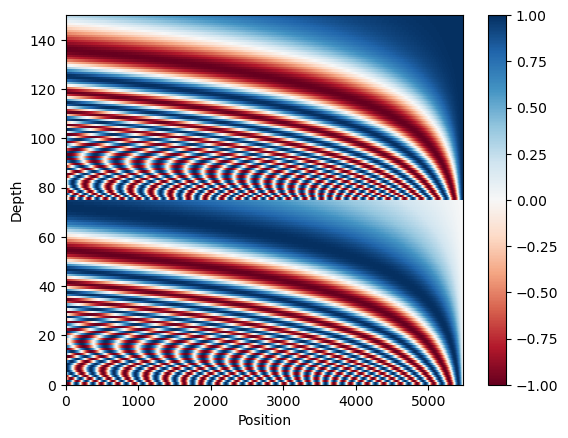

In [24]:
pe = PositionalEmbedding(150)
positions = tf.constant(range(pe.total_days), dtype=tf.int32)
positions = pe.total_days - positions
pcode = tf.gather(pe.total_positional_code, positions)
# print(pcode)
plt.pcolormesh(pcode.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

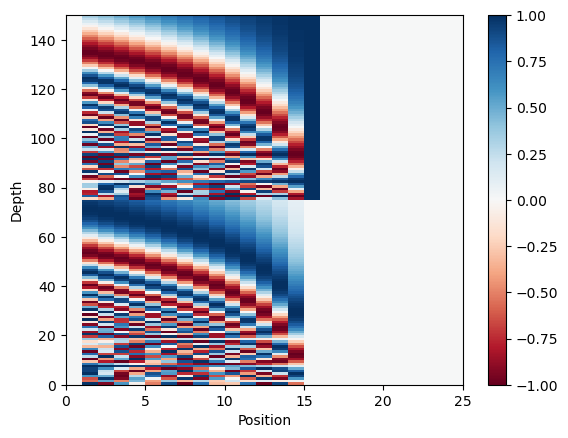

In [25]:
pe = PositionalEmbedding(150)
positions = tf.constant(range(0, 365 * 25, 365), dtype=tf.int32)
positions = pe.total_days - positions
pcode = tf.gather(pe.total_positional_code, positions)
# print(pcode)
plt.pcolormesh(pcode.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [26]:

class hParams:    
    nDivisions = len(DIVIISONS) 
    division_embs = 4   # [0, 1, 2, 3]

    nTeams = tokenizer_team.get_vocab_size()    # including Unknown
    team_embs = TEAM_EMBS
    nGoals  = 4  # [0, 1, 2, 3] Maximum nGoals goals for a team in each of 1st and 2nd halfs. Extra goals will be clipped_by_value.
    goal_embs = 4
    nShoots = 21    # [0, ..., 20]
    shoot_embs = 4 # for combination
    nShootTs = 11   # [0, ..., 10]
    shootT_embs = 4 # for combination
    nCorners = 11   # [0, ..., 10]
    corner_embs = 4 # for combination
    nFauls = 21     # [0, ..., 20]
    faul_embs = 2 # for combination
    nYellows = 5    # [0, ..., 4]
    yellow_embs = 2 # for combination
    
    batch_size = BATCH_SIZE
    days_spanning_years = 30
    num_layers = TRANSFORMER_LAYERS
    num_heads = TRANSFORMER_HEADS
    m365_size = 1
    initial_m365 = 0.9

    # d_model DEPENDS...
    # We want as small d_model as possible, because from which we can freely choose an actual d_model.
    # Tests seem to indicate that larger d_model leads to training overfitting and validation underfitting.
    
    # Where goes ODDS_IN_DECODER ????????????????????

    d_model = 1 * division_embs + 2 * team_embs     # 1 division, 2 teams
    if ODDS_IN_ENCODER: d_model = d_model + NUMBER_QUERIES * NUMBER_BOOKIES  # + NUMBER_QUERIES odds * nBookies
    d_encoder = d_decoder = 0
    if EMBED_AB_COLS:
        d_encoder = d_model + 1 * goal_embs + 1 * goal_embs + 1 * (shoot_embs + shootT_embs + corner_embs + faul_embs + yellow_embs)
        if DECODE_BASE_DATE: d_decoder = d_model + 2 * 4     # 2 * 4 : date details
        else: d_decoder = d_model
    else:   # This mode, EMBED_AB_COLS = False, gives much smaller d_moddel, maybe avoiding overfitting.
        d_encoder = d_model + 1 * len(AB_cols)
        if DECODE_BASE_DATE: d_decoder = d_model + 2 * 4     # 2 * 4 : date details
        else: d_decoder = d_model
    d_model = max(d_encoder, d_decoder)     # (136, 118) for EMBED_AB_COLS, (126, 118) for False EMBED_AB_COLS
    d_model += ADDITIONAL_D_MODEL               # Adjust for the model size and overfitting.
    d_model = d_model + d_model % 2     # make it an even number.
    print("d_model raw: ", d_model)
    d_model = int( (d_model-1) / num_heads) * num_heads + num_heads  # make it a multiple of num_heads, closest to raw d_model.
    print("d_model refined: ", d_model)

d_model raw:  118
d_model refined:  120


In [27]:
class Preprocess(tf.keras.Model):
    def __init__(self, hParams, isEncoder):
        super().__init__()
        self.isEncoder = isEncoder

        # game
        self.division_emb = tf.keras.layers.Embedding(hParams.nDivisions, hParams.division_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown
        self.team_emb = tf.keras.layers.Embedding(hParams.nTeams, hParams.team_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown

        if self.isEncoder:
            if EMBED_AB_COLS:
                # AB_cols
                self.firstH_goal_emb = tf.keras.layers.Embedding(hParams.nGoals * hParams.nGoals, hParams.goal_embs, dtype=tf.float32, mask_zero=False)
                self.secondH_goal_emb = tf.keras.layers.Embedding(hParams.nGoals * hParams.nGoals, hParams.goal_embs, dtype=tf.float32, mask_zero=False)
                self.shoot_emb = tf.keras.layers.Embedding(hParams.nShoots * hParams.nShoots, hParams.shoot_embs, dtype=tf.float32, mask_zero=False)
                self.shootT_emb = tf.keras.layers.Embedding(hParams.nShootTs * hParams.nShootTs, hParams.shootT_embs, dtype=tf.float32, mask_zero=False)
                self.corner_emb = tf.keras.layers.Embedding(hParams.nCorners * hParams.nCorners, hParams.corner_embs, dtype=tf.float32, mask_zero=False)
                self.faul_emb = tf.keras.layers.Embedding(hParams.nFauls * hParams.nFauls, hParams.faul_embs, dtype=tf.float32, mask_zero=False)
                self.yellow_emb = tf.keras.layers.Embedding(hParams.nYellows * hParams.nYellows, hParams.yellow_embs, dtype=tf.float32, mask_zero=False)
            else:
                params = []
                for col in AB_cols:
                    params.append(normalization_parms[col])
                self.AB_mormalization_params = tf.Variable(params, dtype=tf.float32, trainable=False)  # (num AB_cols=14, 3 = <mean, std, maximum>)

        if not self.isEncoder:
            if DECODE_BASE_DATE:
                self.day_emb = tf.keras.layers.Embedding(31, 2, dtype=tf.float32, mask_zero=False)
                self.month_emb = tf.keras.layers.Embedding(12, 2, dtype=tf.float32, mask_zero=False)
                self.wday_emb = tf.keras.layers.Embedding(7, 2, dtype=tf.float32, mask_zero=False)

        if IGNORE_HISTORY: pass
        else: self.dimensional_permution = tf.keras.layers.Dense(hParams.d_model)

        self.idx_Days = BB_cols.index('Date')

    def representDateDetails(self, dateDetails):
        # dateDetails: (batch, 1, 4)
        bYears, bMonths, bDays, bWDays = tf.split(dateDetails, [1, 1, 1, 1], axis=-1)   # All should be of (batch, seq_len = 1, 1)
        bYears = tf.cast(bYears, dtype=tf.float32)  # (batch, seq_len = 1, 1)
        bDays = self.day_emb(bDays)[:, :, -1]       # (batch, seq_len = 1, embs = 2)
        bMonths = self.month_emb(bMonths)[:, :, -1] # (batch, seq_len = 1, embs = 2)
        bWDays = self.wday_emb(bWDays)[:, :, -1]    # (batch, seq_len = 1, embs = 2)
        # w = tf.Variable(np.math.pi / 25, dtype=tf.float32, trainable=False)    # 25 years are covered by pi or a half circle.
        w = np.math.pi / 25
        bYearsCos = tf.math.cos(bYears * w)
        bYearsSin = tf.math.sin(bYears * w)
        bYears = tf.concat([bYearsCos, bYearsSin], axis=-1)   # (batch, seq_len = 1, 1+1 = 2)
        return bYears, bMonths, bDays, bWDays

    def combined_embeddings_of_double_columns(self, emb_layer, columns, nValues):
        # Assume emb_layer = Embedding(nValues * nValues, embs, mask_zero=False)
        cols = tf.cast(columns, dtype=tf.int32)
        cols = tf.clip_by_value(cols, 0, nValues-1)
        combi = cols[:, :, 0] * nValues + cols[:, :, 1]   # (batch, seq_len, 1). [0, ..., nValues * nValues - 1]
        combi = emb_layer(combi)
        return combi    # (batch, seq_len, 1)

    def call(self, x):
        (sequence, base_bb, baseDateDetails, mask) = x # sob = sequence or base_bb
        sequenceDays = sequence[:, :, self.idx_Days]  # (batch, seq_len)
        baseDays = base_bb[:, :, self.idx_Days]   # (batch, 1)

        # sequence follows BBAB, whereas base_bb follows 
        
        # BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols
        # AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

        if self.isEncoder:
            # ramainder: Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols  --- total 12 fields.
            id, div, days, teams, odds, half_goals, full_goals, shoot, shootT, corner, faul, yellow\
            = tf.split(sequence, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), len(Half_Goal_cols), len(Full_Goal_cols), \
                                  len(Shoot_cols), len(ShootT_cols), len(Corner_cols), len(Faul_cols), len(Yellow_cols)], axis=-1)
            # All shape of (batch, sequence, own_cols), all tf.flaot32
        else:
            id, div, days, teams, odds, remainder \
            = tf.split(base_bb, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), -1], axis=-1)  
            # remainder: [] 
            # All shape of (batch, 1, own_cols), guess., all tf.float32
        
        div = self.division_emb(tf.cast(div, dtype=tf.int32))   # (batch, MAX_TOKENS or 1, columns=1, division_embs)
        div = tf.reshape(div, [div.shape[0], div.shape[1], -1]) # (batch, MAX_TOKENS or 1, extended_columns=1*division_embs) --- 
        teams = self.team_emb(tf.cast(teams, dtype=tf.int32))   # (batch, MAX_TOKENS or 1, columns=2, team_embs)
        teams = tf.reshape(teams, [teams.shape[0], teams.shape[1], -1]) # (batch, MAX_TOKENS or 1, extended_columns=2*team_embs) --- 

        if self.isEncoder:
            if EMBED_AB_COLS:
                first_half_goals = self.combined_embeddings_of_double_columns(self.firstH_goal_emb, half_goals, hParams.nGoals)
                second_half_goals = self.combined_embeddings_of_double_columns(self.secondH_goal_emb, full_goals - half_goals, hParams.nGoals)
                shoot = self.combined_embeddings_of_double_columns(self.shoot_emb, shoot, hParams.nShoots)
                shootT = self.combined_embeddings_of_double_columns(self.shootT_emb, shootT, hParams.nShootTs)
                corner = self.combined_embeddings_of_double_columns(self.corner_emb, corner, hParams.nCorners)
                faul = self.combined_embeddings_of_double_columns(self.faul_emb, faul, hParams.nFauls)
                yellow = self.combined_embeddings_of_double_columns(self.yellow_emb, yellow, hParams.nYellows)
                if ODDS_IN_ENCODER: concat = [div, teams, odds, first_half_goals, second_half_goals, shoot, shootT, corner, faul, yellow]
                else: concat = [div, teams, first_half_goals, second_half_goals, shoot, shootT, corner, faul, yellow]

            else:   # normalize now
                # AB_cols = Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols
                AB_values = [half_goals, full_goals, shoot, shootT, corner, faul, yellow]   # all (batch, 2 cols)
                AB_values = tf.concat(AB_values, axis=-1) # (batch, seq_len, num_AB_cols=14)
                # self.AB_mormalization_params  # (num AB_cols=14, 3 = <mean, std, maximum>)
                AB_values = (AB_values - self.AB_mormalization_params[:, 0]) / self.AB_mormalization_params[:, 1]
                if ODDS_IN_ENCODER: concat = [div, teams, odds, AB_values]
                else: concat = [div, teams, AB_values]
        else:
            if DECODE_BASE_DATE:
                bYears, bMonths, bDays, bWDays = self.representDateDetails(baseDateDetails)
                if ODDS_IN_DECODER:  concat = [div, teams, odds, bYears, bMonths, bDays, bWDays]
                else: concat = [div, teams, bYears, bMonths, bDays, bWDays]
            else:
                if ODDS_IN_DECODER: concat = [div, teams, odds]
                else: concat = [div, teams]

        concat = tf.concat(concat, axis=-1)
        assert concat.shape[-1] <= hParams.d_model        

        if IGNORE_HISTORY: pass # concat: (batch, MAX_TOKENS or 1, hParams.d_model)
        else:
            concat = self.dimensional_permution(concat)  # (batch, MAX_TOKENS or 1, hParams.d_model)

        if self.isEncoder:  mask = mask     # (batch, MAX_TOKEN, MAX_TOKEN), although (batch, 1, MAX_TOKEN) will propagate.
        else:   mask = mask[:, 0:concat.shape[1], :]    # concat: (batch, 1, MAX_TOKEN)

        return concat, mask, sequenceDays, baseDays


In [28]:
isEncoder = True
if MODEL_TYPE_CHECK:
    pre = Preprocess(hParams, isEncoder=isEncoder)
    x, mask, seqDays, bDays = pre(sample_x); pre.summary()
    pos = PositionalEmbedding(hParams.d_model)
    x = pos(x, seqDays, bDays, isEncoder=isEncoder); pos.summary()
    @tf.function
    def fun(input):
        x, mask, sequenceDays, baseDays = pre(input)
        x = pos(x, sequenceDays, baseDays, isEncoder=isEncoder)
        return x, mask, sequenceDays, baseDays
    x, mask, sequenceDays, baseDays = fun(sample_x)
    print(x.shape, mask.shape, sequenceDays.shape, baseDays.shape)
    del pre, pos

In [29]:
isEncoder = False
if MODEL_TYPE_CHECK:
    pre = Preprocess(hParams, isEncoder=isEncoder)
    x, mask, seqDays, bDays = pre(sample_x); pre.summary()
    pos = PositionalEmbedding(hParams.d_model)
    x = pos(x, seqDays, bDays, isEncoder=isEncoder); pos.summary()
    @tf.function
    def fun(input):
        x, mask, sequenceDays, baseDays = pre(input)
        x = pos(x, sequenceDays, baseDays, isEncoder=isEncoder)
        return x, mask, sequenceDays, baseDays
    x, mask, sequenceDays, baseDays = fun(sample_x)
    print(x.shape, mask.shape, sequenceDays.shape, baseDays.shape)
    del pre, pos

In [30]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
      # tf.keras.layers.Dropout(dropout_rate)
  ])

def scaled_dot_product_attention(q, k, v, mask=None):
  """
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v), seq_len_k == sel_len_v
    mask: Float 0/1 tensor with shape broadcastable to (..., seq_len_q, seq_len_k). 1 surpresses the score to zero.
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # (..., seq_len_q, seq_len_k)

  if mask is not None: scaled_attention_logits += (tf.cast(mask, dtype=tf.float32) * -1e9)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len_q, d_model)
    k = self.wk(k)  # (batch_size, seq_len_k, d_model)
    v = self.wv(v)  # (batch_size, seq_len_v, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, d_head)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, d_head)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, d_head)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, d_head)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, d_head)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights


class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):
    # value = x, key = x, query = x
    self_att, self_att_weights = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    self_att = self.dropout1(self_att, training=training)
    out1 = self.layernorm1(x + self_att)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out
  
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, context, training, 
           look_ahead_mask, padding_mask):
    # x: (batch, target_seq_len, d_model), context.shape: (batch_size, input_seq_len, d_model)

    # value = x, key = x, query = x
    self_att, self_att_weights = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len = 1, d_model)
    self_att = self.dropout1(self_att, training=training)
    self_att = self.layernorm1(self_att + x)

    # value = context, key = context, query = self_att
    cross_att, cross_att_weights = self.mha2(context, context, self_att, padding_mask)  # (batch_size, target_seq_len, d_model)
    cross_att = self.dropout2(cross_att, training=training)
    out2 = self.layernorm2(cross_att + self_att)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out, self_att_weights, cross_att_weights
  
class Encoder(tf.keras.layers.Layer):
    def __init__(self, hParams, dropout_rate=0.1):
      super().__init__()
      self.d_model = hParams.d_model
      self.num_layers = hParams.num_layers
      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.enc_layers = [
          EncoderLayer(d_model=hParams.d_model, num_heads=hParams.num_heads, dff=hParams.d_model * 4, rate=dropout_rate)
          for _ in range(hParams.num_layers)]

    def call(self, x, training, encMask):
      x = self.dropout(x, training=training)
      for encoder_layer in self.enc_layers:
        x = encoder_layer(x, training, encMask)
      return x  # (batch_size, max_tokens, d_model)
 
class Decoder(tf.keras.layers.Layer):
    def __init__(self, hParams, dropout_rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = hParams.d_model
      self.num_layers = hParams.num_layers
      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      if IGNORE_HISTORY: pass
      else:
        self.dec_layers = [
            DecoderLayer(d_model=hParams.d_model, num_heads=hParams.num_heads, dff=hParams.d_model * 4, rate=dropout_rate)
            for _ in range(hParams.num_layers)]

    def call(self, x, context, training, look_ahead_mask, padding_mask):
      if IGNORE_HISTORY: pass
      else:
        x = self.dropout(x, training=training)
        for decoder_layer in self.dec_layers:
          x, _, _  = decoder_layer(x, context, training, look_ahead_mask, padding_mask)
      return x
  
class Transformer(tf.keras.Model):
    def __init__(self, hParams, dropout_rate=0.1):
      super().__init__()
      if IGNORE_HISTORY:
        self.all_one_context = tf.ones((BATCH_SIZE, MAX_TOKENS, hParams.d_model), dtype=tf.float32) # (batch, max_tokens, d_model)
      else:
        self.encPreprocess = Preprocess(hParams, isEncoder=True)
        self.decPreprocess = Preprocess(hParams, isEncoder=False)
        self.posEmbedding = PositionalEmbedding(hParams.d_model)
        self.encoder = Encoder(hParams, dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(hParams.d_model) #-------------- to modify
      self.decoder = Decoder(hParams, dropout_rate=dropout_rate)
      self.one = tf.constant(1, dtype=tf.int32)

    def call(self, input, training=False):
      # inputs = (sequence, base_bb, baseDateDetails, mask)
      # sequence: (batch, max_token, aabb), base: (batch, 1, bb), baseDateDetails: (batch, 1, 4), mask: (batch, max_token, max_token)
      if IGNORE_HISTORY: 
        context = self.all_one_context
      else:
        x, encMask, sequenceDays, baseDays = self.encPreprocess(input) # (batch, max_tokens, d_model), (batch, max_tokens, max_tokens), (batch, max_tokens), (batch, 1)
        x = self.posEmbedding(x, sequenceDays, baseDays, isEncoder=True) # (batch, max_tokens, d_model)
        encMask = self.one - encMask    # NEGATE !!! forgoten for two YEARS !!!
        encMask = encMask[:, tf.newaxis, :, :]  # newaxis: head
        context = self.encoder(x, training, encMask)  # (batch, max_tokens, d_model). Only sequence and mask are used.

      x, decMask, sequenceDays, baseDays = self.decPreprocess(input) # (batch, 1, d_model), (batch, 1, max_tokens), (batch, max_tokens), (batch, 1)
      x = self.posEmbedding(x, sequenceDays, baseDays, isEncoder=False) # (batch, 1, d_model)
      decMask = decMask[:, tf.newaxis, :, :]
      # look_ahead_mask is None, which means [[0]], as there is only one position in x, so is nothing to mask when doing mha(value=x, key=x, query=x).
      x = self.decoder(x, context, training, look_ahead_mask=None, padding_mask=decMask)  # (batch, 1, d_model).  Only base_bb, baseDateDetails, and mask are used.      

      logits = self.final_layer(x)  # (batch, 1, d_model)
      logits = tf.squeeze(logits, axis=-2)  # (batch, d_model)

      return logits

In [31]:
if MODEL_TYPE_CHECK:
    sample_transformer = Transformer(hParams, dropout_rate=DROPOUT)
    y = sample_transformer(sample_x, training=True)
    sample_transformer.summary()

    @tf.function
    def fun(x):
        y = sample_transformer(x, training=False)
        return y
    y = fun(sample_x)
    print(y.shape)
    del sample_transformer


In [32]:
class Dense_Add_Norm(tf.keras.layers.Layer):
    def __init__(self, dim, seed):
      super().__init__()
      self.dense =tf.keras.layers.Dense (dim, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=seed), bias_initializer=Zeros, activation='tanh')
      self.add = tf.keras.layers.Add()
      self.layernorm = tf.keras.layers.LayerNormalization()
    def call(self, x):
      dense = self.dense(x, training=False)
      x = self.add([x, dense])  # x.shape[-1] == dim
      x = self.layernorm(x)
      return x

Zeros = tf.keras.initializers.Zeros()

# Used for earlier versions that don't allow mixing bookies.
class Adaptor(tf.keras.Model):
  def __init__(self, nLayers, d_main, d_output, dropout_rate=0.1):
    super().__init__()
    # total (nLayers + nLayers) dims = 2 * nLayers dims
    dims = [d_main] * nLayers
    layers = [Dense_Add_Norm(dims[id], id) for id in range(len(dims))]
    self.seq = tf.keras.Sequential(layers)
    self.initial = tf.keras.layers.Dense (d_main, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=23), activation='tanh')
    self.final = tf.keras.layers.Dense (d_output, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=23), activation='tanh')
  def call(self, x, training=False):  # (batch, d_model)
    x = self.initial(x)
    x = self.seq(x)   # (batch, d_model)
    x = self.final(x) # (batch, nBookies * NUMBER_QUERIES)
    return x

In [33]:
std_mean = tf.Variable([normalization_parms[col][0] for col in Odds_cols], trainable=False)
std_variation = tf.Variable([normalization_parms[col][1] for col in Odds_cols], trainable=False)
print(std_mean.shape, std_variation.shape)

# No, _Label_cols were not normalized.

(15,) (15,)


In [34]:
class Model_1X2(tf.keras.Model):
    softmax = tf.keras.layers.Softmax(axis=-1)

    def __init__(self, hParams, nQueries, dropout_rate=0.1):
        super().__init__()
        self.nQueries = nQueries
        self.transformer = Transformer(hParams, dropout_rate=dropout_rate)
        #   self.bookies = ['B365', 'Betfair', 'Interwetten', 'William']
        self.bookies = ['HDA' + str(b) for b in range(NUMBER_BOOKIES)]

        if SIMPLIFY_ADAPTOR:
            self.adaptor = tf.keras.layers.Dense(len(self.bookies) * self.nQueries)
        else:
            self.adaptor = Adaptor(ADAPTORS_LAYERS, hParams.d_model * ADAPTORS_WIDTH_FACTOR, self.nQueries * len(self.bookies))
     
        if LOSS_TYPE == 'entropy':
            self.categorical_crossentropy = tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size')
        return

    def call(self, x, trainig=False):
        x = self.transformer(x, training=trainig) # (batch, d_model)
        output = self.adaptor(x)   # (batch, nBookies * nQueries)
        output = tf.reshape(output, [output.shape[0], self.nQueries, -1])    # (batch, nQueries, nBookies)
        output = tf.transpose(output, perm=[2, 0, 1])     # (nBookies, batch, nQueries)
        if MODEL_ACTIVATION == 'softmax':
            output = tf.nn.softmax(output)  # (nBookies, batch, nQueries)   #
        elif MODEL_ACTIVATION == 'sigmoid':
            output = tf.math.sigmoid(output * 5)  # the previous activation is tanh, ranging (-1, 1). Multiplier 5 will result in range (near 0, near 1)
        elif MODEL_ACTIVATION == 'relu':
            output = tf.nn.relu(output)
        elif MODEL_ACTIVATION == 'open':
            pass    # output = output
        return output   # (nBookies, batch, nQueries)
    
    def h_true(self, ftGoals):  # Defines this QGroup. This is for 1X2 QGroup. Derived classes re-define this funciton.
        # ftGoals:  (batch, 2)
        ftGoals = tf.cast(ftGoals, dtype=tf.int32)  # (batch, 2)
        h = (tf.math.greater(ftGoals[..., 0], ftGoals[..., 1]), tf.math.equal(ftGoals[..., 0], ftGoals[..., 1]), tf.math.less(ftGoals[..., 0], ftGoals[..., 1]))
        h = tf.cast(tf.transpose(h), dtype=tf.float32)  # (batch, nQueries)
        return h

    def loss(self, y, output):   
        # y: (batch, len(Team_cols)+len(Odds_cols)) 
        # output: (nBookies, batch, nQueries)

        def well(x, mu, sigma):
            norm = tf.norm(x)
            return tf.nn.relu(norm - sigma) * 0.5   # so this component of loss is less steep than the other component.
            # return - tf.math.exp(- tf.math.pow((x-mu)/sigma, 2) / 2) / (sigma * tf.math.sqrt(np.pi*2))

        ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, self.nQueries * len(self.bookies))
        odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
        odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)
        happen_t = self.h_true(ftGoals) # (batch, nQueries)
        oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)

        if LOSS_TYPE != 'entropy':
            (stake_p) = output  # (nBookies, batch, nQueries)
            # -----------------------------------------------------------------------------------------
            # Note: happen_p and stake_p are not converted to one-hot values, unlike they should.
            # Note: Do not normalize stake_p. It can learn whether to bet or not, as well as betting direction.
            #------------------------------------------------------------------------------------------
            profit_per_bookie_game = tf.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1)    # (nBooies, batch)
            mean_profit_by_game = tf.reduce_mean(profit_per_bookie_game, axis=0)    # (batch,)
            profit_backtest_sum = tf.reduce_sum(mean_profit_by_game, axis=None)  # () 
            loss_sum = - profit_backtest_sum  # U.action.42

            if MODEL_ACTIVATION == 'open':
                bell_loss = well(stake_p, 0, 2)
                loss += bell_loss

            if not VECTOR_BETTING:
                one_hot_stake_p = tf.squeeze(tf.one_hot(tf.nn.top_k(stake_p).indices, tf.shape(stake_p)[-1]), axis=-2)   # one_hot stake_p, (nBookies, batch, nQueries)
                profit_per_bookie_game = tf.reduce_sum(tf.math.multiply(oh - 1.0, one_hot_stake_p), axis=-1)    # (nBooies, batch)
                mean_profit_by_game = tf.reduce_mean(profit_per_bookie_game, axis=0)    # (batch,)
                profit_backtest_sum = tf.reduce_sum(mean_profit_by_game, axis=None)  # ()

        else:
            probability_p = tf.transpose(output, perm=[1, 2, 0])
            probability_p = tf.math.reduce_mean(probability_p, axis=-1) # (batch, nQueries)
            loss_sum = self.categorical_crossentropy(happen_t, probability_p)   # reduce sum over batch size. What over the axis -1.

            one_hot_stake_p = tf.squeeze(tf.one_hot(tf.nn.top_k(probability_p).indices, tf.shape(probability_p)[-1]), axis=1)   # one_hot stake_p
            profit_per_bookie_game = tf.reduce_sum(tf.math.multiply(oh - 1.0, one_hot_stake_p), axis=-1)    # (nBooies, batch)
            mean_profit_by_game = tf.reduce_mean(profit_per_bookie_game, axis=0)    # (batch,)
            profit_backtest_sum = tf.reduce_sum(mean_profit_by_game, axis=None)  # ()
    
        return loss_sum, profit_backtest_sum, mean_profit_by_game # (), (), (batch,)  Both loss_sum and profit_backtest_sum are a sum across batch. 
    
    
    def backtest_event_wise(self, y, output, key_a, key_b):
        # y: (batch, len(Team_cols)+len(Odds_cols)) 
        # output: (nBookies, batch, nQueries)
        ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2)!, (batch, self.nQueries * len(self.bookies))
        odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
        odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)!
        # odds and tfGoals were not normalized, so you don't need de-normalize them.
        happen_t = self.h_true(ftGoals) # (batch, nQueroes)
        oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)
        (stake_p) = output

        # -----------------------------------------------------------------------------------------
        # Note: oh_p and stake_p are not converted to one-hot values, unlike they should.
        #------------------------------------------------------------------------------------------
        def analyze(stake_p):
            # sum_stake_p = tf.math.reduce_sum(stake_p, axis=-1)
            norm = tf.norm(stake_p, keepdims=True, axis=-1) + 1e-12
            profit_p = tf.math.reduce_sum(tf.math.multiply(odds * (stake_p / norm) - 1.0, stake_p), axis=-1)# (nBookies, batch)
            profit_backtest = tf.math.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1) # (nBookies, batch)
            condition = tf.math.logical_and(key_a <= profit_p, profit_p <= key_b)   # (nBookies, batch), dtype=tf.bool
            indices = tf.where(condition)   # (n, 2)    values: (bookieId, gameId)
            profit_backtest = profit_backtest[condition]  # (n,)    values: (profit)
            stake = stake_p[condition]  # (n, nQueries)
            # assert indices.shape[0] == profit_backtest.shape[0]
            return indices, stake, profit_backtest

        if VECTOR_BETTING:
            indices, stake, profit_backtest = analyze(stake_p)
        else:
            bestQuery = tf.argmax(stake_p, axis=-1)     #   (nBookies, batch, nQueries)
            stake_p = tf.one_hot(bestQuery, self.nQueries, dtype=tf.float32)   #   (nBookies, batch, nQueries)
            indices, stake, profit_backtest = analyze(stake_p)

        # assert indices.shape[0] == profit_backtest.shape[0]
        return indices, stake, profit_backtest  # Not normalized. i.e. not divided with the norm of stake_p
    
    def get_batch_backtest(self, y, output):
        # y: (batch, len(Team_cols)+len(Odds_cols)) 
        # output: (nBookies, batch, nQueries)
        ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2)!, (batch, self.nQueries * len(self.bookies))
        odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
        odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)!
        # odds and tfGoals were not normalized, so you don't need de-normalize them.
        happen_t = self.h_true(ftGoals) # (batch, nQueroes)
        oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)
        (stake_p) = output
        sum = tf.math.reduce_sum(stake_p, keepdims=True, axis=-1) + 1e-12
        indicatorP = tf.math.reduce_sum(tf.math.multiply(odds * (stake_p / sum) - 1.0, stake_p), axis=-1)  # (nBookies, batch)
        backtestP = tf.math.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1)  # (nBookies, batch)
        indices = tf.where(indicatorP == indicatorP)    # (nBookies * batch, 2 [bookieId, rel_gameId])
        indicatorP = tf.reshape(indicatorP, [-1])   # (nBookies * batch, )
        backtestP = tf.reshape(backtestP, [-1])     # (nBookies * batch, )
        stake_p = tf.reshape(stake_p, [-1, self.nQueries])
        # (nBookies * batch,), (nBookies * batch,), (nBookies * batch, 2 [bookieId, rel_gameId]), (nBookies * batch, 3 [nQueries])
        return indicatorP, backtestP, indices, stake_p
    
dummy_mean_profit_per_game = None
class Model_Filter(Model_1X2):
    def __init__(self, hParams, nQueries, dropout_rate=0.1):
        super().__init__(hParams, nQueries, dropout_rate=dropout_rate)
        self.bce = tf.losses.BinaryCrossentropy(from_logits=False)
        return

    def call(self, x, training=False):
        x = self.transformer(x, training=training) # (batch, d_model)
        stake_p = self.adaptor(x)   # (batch, nBookies * nQueries)
        stake_p = tf.reshape(stake_p, [stake_p.shape[0], self.nQueries, -1])    # (batch, nQueries, nBookies)
        stack = [stake_p[:, :, b] for b in range(len(self.bookies))]    # NNNNo way to swap axes efficiently.
        stake_p = tf.stack(stack, axis=0)   # (nBookies, batch, nQueries)
        stake_p = tf.math.reduce_mean(stake_p, axis=-1) # (nBookies, batch)
        stake_p = tf.math.reduce_mean(stake_p, axis=0) # (batch,)
        stake_p = tf.math.sigmoid(stake_p * 5)          # (batch,)
        return stake_p
    
    def loss(self, y, output):   
        # y: (batch,) 
        # output: (batch,)
        loss = self.bce(y, output)
        return loss, dummy_mean_profit_per_game

def create_model_object(model_class):
    try: model_c
    except NameError: pass
    else: del model_c
    try: model_1x2
    except NameError: pass
    else: del model_1x2
    tf.keras.backend.clear_session(); gc.collect()
    model = model_class(hParams, nQueries=NUMBER_QUERIES, dropout_rate=DROPOUT)   # Do not create a reference and return directly.
    return model

In [35]:
model_1x2 = create_model_object(Model_1X2)

if MODEL_TYPE_CHECK:
    output = model_1x2(sample_x, training=True)
    @tf.function
    def fun(x, y):
        output = model_1x2(x, training=False)
        loss_sum, profit_sum, profits = model_1x2.loss(y, output)
        return output, loss_sum, profit_sum, profits
    output, loss_sum, profit_sum, profits = fun(sample_x, sample_y)
    print(output.shape, loss_sum.shape, profit_sum.shape, profits.shape)

    model_1x2.summary()
    # del model_1x2

In [36]:
# tf.keras.utils.plot_model(model_1x2, show_shapes=True, dpi=48)

In [37]:
# @tf.function  #-------------------- Weird: no work.
def backtest_with_dataset(dataset, profit_keys):
    profits = [-1.0] * len(profit_keys)
    casts = [0] * len(profit_keys)
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask); y = value

        outputs = model_1x2(x, training=False)  #
        profit_list, cast_list = model_1x2.backtest(y, outputs, profit_keys)

        for p, c, id in zip(profit_list, cast_list, range(len(profit_keys))):
            if c > 0:
                profits[id] = (profits[id] * casts[id] + p * c) / (casts[id] + c)
                casts[id] = casts[id] + c
    # print('key', profit_back_mean, nBettingsTotal)
    return profits, casts

# @tf.function  #-------------------- Weird: no work.
def backtest_event_wise_with_dataset(ds_batches, model, key_a, key_b):
    indices = []; stakes = []; profits = []
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(ds_batches):
        x = (sequence, base_bb, baseDateDetails, mask); y = value

        outputs = model(x, training=False)  #
        new_indices, new_stakes, new_profits = model.backtest_event_wise(y, outputs, key_a, key_b)  # Tensor (n, 2 <bookieId, rel_gameId>), (n, nQueries), (n,)

        new_indices = [list(id) for id in new_indices.numpy()]  # [[0,2], ..., [bookie, rel_game_id]]. No tuple but list.
        baseId = list(baseId.numpy())   # absolute game ids
        new_indices = [[bookie, baseId[rel_game_id]] for [bookie, rel_game_id] in new_indices]
        indices = indices + new_indices     # [[0, 123], ..., [[bookie, gameId]]], len = n

        new_stakes = [list(stake) for stake in new_stakes.numpy()]  # [[sHWin, sDraw, sAWin], ...] No tuple but list
        stakes = stakes + new_stakes

        new_profits = list(new_profits.numpy())                 # [0.3, ...]
        profits = profits + new_profits     # [1.3, ..., profit], len = n

    interval_backtests = [(bookie, gameId, stake, profit) for (bookie, gameId), stake, profit in zip(indices, stakes, profits)]  # [ [bookieId ,gameId, (sHWin, sDraw, sAway), p], ...  ]
    return interval_backtests     # [(bookie, gameId, profit) for ...]

# @tf.function  #-------------------- Weird: no work.
def get_backtest_and_indicator_profits(dataset):
    backtestP = indicatorP = []
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask); y = value
        outputs = model_1x2(x, training=False)  #
        new_indicatorP, new_backtestP = model_1x2.get_backtest_and_indicator_profits(y, outputs)    # Tensor (nBookies * batch), (nBookies * batch)
        indicatorP = indicatorP + list(new_indicatorP.numpy())
        backtestP = backtestP + list(new_backtestP.numpy())
    return indicatorP, backtestP

#-------------------------------------------------------------------------------------------------------------------------------------------------
def get_key_a_key_b(indicatorP, backtestP, indices, stakes, threshold=0.0):
    backtestP = np.array(backtestP, dtype=np.float32)
    indicatorP = np.array(indicatorP, dtype=np.float32)
    indices = np.array(indices, dtype=np.int32)
    stakes = np.array(stakes, dtype=np.float32)
    idx = np.argsort(indicatorP)
    indicatorP = indicatorP[idx]    # increasing order
    backtestP = backtestP[idx]      # hope to be increading order
    indices = indices[idx]
    stakes = stakes[idx]

    ab = []
    for w in range(30, int(len(backtestP))):    # 30
        back = np.convolve(backtestP, np.ones(w), mode='valid') - threshold
        ab += [(back[i], i, i+w-1) for i in range(len(back))]   # [ i : i + w ] : w points. inclusive boundaries.
    ab = [(p, a, b) for (p, a, b) in ab if p > 0]   # a, b : inclusive
    ab.sort(reverse=False)  # False !   The larger the profit, the earlier it comes in ab.
    AB = ab.copy()
    for i in range(len(ab)):   # less valuable intervals are screened first.
        interval_i = ab[i];  P, A, B = interval_i    # sure A < B
        intersects = False
        for j in range(i+1, len(ab)):
            interval_j = ab[j]; p, a, b = interval_j    # sure a < b
            if not (b < A or B < a): intersects = True; break
        if intersects:  AB.remove(interval_i)   # interval_i is unique in AB
    AB.sort(reverse=True); AB = AB[:5]
    print("AB: ", AB)
    [interval_profit, idx_a, idx_b] = AB[0]     # idx_a, idx_b : inclusive
    keyPairs = [[indicatorP[a], indicatorP[b]] for (B, a, b) in AB]
    (key_a, key_b) = keyPairs[0]

    return indicatorP, backtestP, indices, stakes, interval_profit, key_a, key_b, idx_a, idx_b

# @tf.function  # gives a wrong result of tf.where(profit_p > key)
def inference_step(x, odds, interval_a, interval_b):
    stake_p = model_1x2(x, training=False)    # (nBookies, batch, nQueries)
    nQueries = stake_p.shape[-1]
    profit_p = tf.math.reduce_sum(tf.math.multiply(odds * stake_p - 1.0, stake_p), axis=-1)  # (nBookies, batch)

    bet_bool = interval_a <= profit_p and profit_p >= interval_b    # (nBookies, batch)
    bet_bool = tf.stack([bet_bool] * nQueries, axis=-1) # (nBookies, batch, nQueries)
    stake_vector = tf.math.multiply(stake_p, tf.cast(bet_bool, dtype=tf.float32))   # (nBookies, batch, nQueries)
    stake_vector = tf.reshape(stake_vector, [1, 0, 2])  # (batch, nBookies, nQueries)
    return stake_vector

# @tf.function  #-------------------- Weird: no work.
def inference_with_dataset(dataset, interval_a, interval_b): 
    vectors = []
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask)
        id, div, days, teams, odds, remainder \
            = tf.split(base_bb, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), -1], axis=-1)
        stake_vector = inference_step(x, odds, interval_a, interval_b)  # (batch, nBookies, nQueries)
        vectors.append(stake_vector)
    
    stake_vectors = tf.concat(vectors, axis=0)   # (batch, nBookies, nQueries)
    return stake_vectors    # (batch, nBookies, nQueries)

def get_dataset_backtest(model, dataset):
    backtestP = indicatorP = indices = stakes = []

    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask); y = value
        outputs = model(x, training=False)
        # (nBookies * batch,), (nBookies * batch,), (nBookies * batch, 2 [bookieId, rel_gameId]), (nBookies * batch, 3 [nQueries])
        new_indicatorP, new_backtestP, new_indices, new_stakes = model.get_batch_backtest(y, outputs)
        indicatorP = indicatorP + list(new_indicatorP.numpy())  # + [1.2, ...], len = nBookies * batch
        backtestP = backtestP + list(new_backtestP.numpy())     # + [1.2, ...], len = nBookies * batch

        new_indices = [list(id) for id in new_indices.numpy()]  # [[0,2], ...], len = nBookies * batch. No tuple but list.
        baseId = list(baseId.numpy())   # absolute game ids
        new_indices = [[bookie, baseId[rel_game_id]] for [bookie, rel_game_id] in new_indices]
        indices = indices + new_indices     # + [[0, 1000123], ..., [[bookie, gameId]]], len = nBookies * batch

        new_stakes = [list(stake) for stake in new_stakes.numpy()]  # [[sHWin, sDraw, sAWin], ...] No tuple but list
        stakes = stakes + new_stakes    # + [[sHWin, sDraw, sAWin], ...], len = nBooks * batch

    indicatorP_permuted, backtestP_permuted, indices_permutated, stakes_permutated, interval_profit, interval_a, interval_b, idx_a, idx_b = \
        get_key_a_key_b(indicatorP, backtestP, indices, stakes, threshold=0.0)  # idx_a, idx_b : inclusive

    interval_backtests = [(bookie, gameId, list(stake), profit) for (bookie, gameId), stake, profit in \
        zip(indices_permutated[idx_a:idx_b+1], stakes_permutated[idx_a:idx_b+1], backtestP_permuted[idx_a:idx_b+1])]  # [ [bookieId ,gameId, (sHWin, sDraw, sAway), p], ...  ]

    return interval_backtests, indicatorP_permuted, backtestP_permuted, interval_a, interval_b, interval_profit, idx_a, idx_b

class Adam_exponential(tf.keras.optimizers.Adam):
    def __init__(self, initial_step, starting_rate, ex_step, ex_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-12):
        self.step = tf.Variable(initial_step, dtype=tf.float32, trainable=False)
        learning_rate = tf.compat.v1.train.exponential_decay(starting_rate, self.step, ex_step, ex_rate/starting_rate, staircase=False)
        super().__init__(learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)


In [38]:
class history_class():
    def round_sig(self, x, sig=2):
            return x
            # return round(x, sig-int(math.floor(math.log10(abs(x))))-1)    # domain error for VERY small numbers.
    def __init__(self, filepath):
        self.filepath = filepath
        self.history = {'initial_profit': -float('inf'), 'loss': [], 'val_loss_0': [], 'val_profit_0': [], 'val_loss': [], 'val_profit': [], 'learning_rate': [], 'recall': [], 'precision': [], 'time_taken': [],  'gauge': [], 'backtest_reports': []}
    def set_initial_interval_profit(self, initail_inverval_profit):
        self.history['initial_profit'] = initail_inverval_profit
        self.save()
    def removeFile(self):
        files = glob.glob(self.filepath + "*")   # "*.*" may not work
        result = [os.remove(file) for file in files]
    def save(self):
        YH_assistant.SaveJsonData(self.history, self.filepath)
    def reset(self):
        self.removeFile()
        # forgot to reset self.history? ---------------------- Check it.
        self.__init__(self.filepath)
        self.save()
    def load(self):
        history = YH_assistant.LoadJsonData(self.filepath)
        if history is not None: self.history = history

    def append(self, train_loss, val_loss_0, val_profit_0, val_loss, val_profit, learning_rate, recall, precision, time_taken, gauge, backtest_report):
        self.history['loss'].append(self.round_sig(train_loss, 4))
        self.history['val_loss_0'].append(self.round_sig(val_loss_0, 4))
        self.history['val_profit_0'].append(self.round_sig(val_profit_0, 4))
        self.history['val_loss'].append(self.round_sig(val_loss, 4))
        self.history['val_profit'].append(self.round_sig(val_profit, 4))
        self.history['learning_rate'].append(learning_rate)
        self.history['recall'].append(self.round_sig(recall, 4))
        self.history['precision'].append(self.round_sig(precision, 4))
        self.history['time_taken'].append(time_taken)
        self.history['gauge'].append(gauge)
        self.history['backtest_reports'].append(backtest_report)
        self.save()

    def get_zipped_history(self):
        z = zip(self.history['loss'], self.history['val_loss_0'], self.history['val_profit_0'], self.history['val_loss'], self.history['val_profit'], self.history['learning_rate'], self.history['recall'], self.history['precision'], self.history['time_taken'])
        return list(z)
    # def append_backtests(self, epoch, key_a, key_b, interval_profit, backtest):
    #     self.history['backtests'].append((epoch, key_a, key_b, interval_profit, backtest))
    #     self.save()
    def get_backtest_report(self, epoch):
        return self.history['backtest_reports'][epoch]     # sure exists. epoch is selected.
    def len(self):
        assert len(self.history['loss']) == len(self.history['val_loss_0'])
        assert len(self.history['loss']) == len(self.history['val_profit_0'])
        assert len(self.history['loss']) == len(self.history['val_loss'])
        assert len(self.history['loss']) == len(self.history['val_profit'])
        assert len(self.history['loss']) == len(self.history['recall'])
        assert len(self.history['loss']) == len(self.history['precision'])
        assert len(self.history['loss']) == len(self.history['learning_rate'])
        assert len(self.history['loss']) == len(self.history['time_taken'])
        assert len(self.history['loss']) == len(self.history['gauge'])
        assert len(self.history['loss']) == len(self.history['backtest_reports'])
        return len(self.history['loss'])
    def get_min_val_loss(self):
        return float('inf') if self.len() <= 0 else min(self.history['val_loss'])
    def get_max_gauge(self, epoch):
        gauges = self.history['gauge']
        return -float('inf') if (len(gauges) <= 0 or epoch <= 0) else max(gauges[:epoch])
    def replace_gauge(self, epoch, gauge):
        self.history['gauge'][epoch] = gauge;   self.save()
    def show(self, ax, show_val_0=True):
        ax.set_title(TEST_ID + ": loss history: " + str(max(self.history['gauge']) if len(self.history['gauge']) > 0 else 0))

        ax.plot(self.history['loss'], label='train_loss')
        if show_val_0: ax.plot(self.history['val_loss_0'], label='GET_VAL_LOSS_0')
        ax.plot(self.history['val_loss'], label='val_loss')
        ax.plot([-v for v in self.history['val_loss']], label='vector_profit')
        ax.plot(self.history['val_profit'], label='scalar_profit')
        
        ax.legend(loc='lower left')
        ax.grid(True)
        ax.set_ylabel('loss or profit')
        ax.set_xlabel('epoch', loc='right')

In [39]:
class recall():
  def __init__(self, **kwargs):
    self.n = None
    self.recall = None
    self.reset()

  def update(self, label, pred):    # (batch,)
    label = tf.cast(label, dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)
    hit_positives = tf.math.reduce_sum(label * pred, axis=None)
    labeled_positives = tf.math.reduce_sum(label, axis=None)
    recall = hit_positives / (labeled_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.recall = self.recall * (self.n-1)/self.n + recall / self.n

  def result(self):
    return self.recall
  
  def reset(self):
    self.n = 0
    self.recall = tf.Variable(0.0, dtype=tf.float32, trainable=False)
  
recall_object = recall(min_seq_len=5)

class precision():
  def __init__(self, **kwargs):
    self.n = None
    self.precision = None
    self.reset()

  def update(self, label, pred):
    label = tf.cast(label, dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)
    hit_positives = tf.math.reduce_sum(label * pred, axis=None)
    predicted_positives = tf.math.reduce_sum(pred, axis=None)
    precision = hit_positives / (predicted_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.precision = self.precision * (self.n-1)/self.n + precision / self.n

  def result(self):
    return self.precision
  
  def reset(self):
    self.n = 0
    self.precision = tf.Variable(0.0, dtype=tf.float32, trainable=False)

precision_object = precision(min_seq_len=5)

In [40]:
@tf.function    # Removing this decoration leads to GPU OOM!!!
def train_step(model, optimizer, x, y):
    
    with tf.GradientTape() as tape:
        outputs = model(x, training=True)  # (nBookies, batch, nQueries)
        loss_sum, _, _ = model.loss(y, outputs)    # (), (), (batch,)

    grads = tape.gradient(loss_sum, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    del tape    # new
    return loss_sum  # (), (batch,)

@tf.function
def find_loss_for_step(model, x, y):
    outputs = model(x, training=False)  # (nBookies, batch, nQueries)
    loss_sum, profit_sum, profits = model.loss(y, outputs)    # (), (), (batch,)
    return loss_sum, profit_sum, profits #, profits

def find_loss_for_dataset(model, ds_batches):
    prev_nSum = new_nSum = 0
    avg_loss = tf.Variable(0.0, dtype=tf.float32, trainable=False) 
    avg_profit = tf.Variable(0.0, dtype=tf.float32, trainable=False)
    total_profits = tf.Variable([0.0], dtype=tf.float32, trainable=False)
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(ds_batches):
        x = (sequence, base_bb, baseDateDetails, mask); y = value
        loss_sum, profit_sum, profits = find_loss_for_step(model, x, y)
        batch_size = baseId.shape[0]
        new_nSum += batch_size  # += baseId.shape[0], given sum of loss and profit. Ignore that the last batch might be smaller than others.
        avg_loss = avg_loss * prev_nSum / new_nSum + loss_sum / new_nSum
        avg_profit = avg_profit * prev_nSum / new_nSum + profit_sum / new_nSum
        prev_nSum = new_nSum
        total_profits = tf.concat([total_profits, profits], axis=-1)
    return avg_loss, avg_profit, total_profits    # agerage loss and backtest_profit per game

# @tf.function
def find_recall_precision(model, ds_batches):
    recall_object.reset(); precision_object.reset()
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (y)) in enumerate(ds_batches):
        x = (sequence, base_bb, baseDateDetails, mask)
        pred = model(x, training=False)
        pred = tf.cast(pred > 0.5, dtype=tf.int32)
        # Wrong. transorm y to label.   #-------------------------------------------------------- Wrong
        recall_object.update(y, pred); precision_object.update(y, pred)
    return recall_object.result(), precision_object.result()

def replace_baseLabel_with_profitable(model, ds_batches, threshold=0.0001):     # ds_batches: either train_batches or valid_batches
    def generator():
        count = 0
        for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (base_label)) in enumerate(ds_batches):
            x = (sequence, base_bb, baseDateDetails, mask); y = base_label
            # print('3', sequence.shape, base_bb.shape, baseDateDetails.shape, mask.shape, y.shape)
            _, mean_profit_per_game = find_loss_for_step(model, x, y)  # (), (batch,)
            profitable = tf.cast(mean_profit_per_game >= threshold, dtype=tf.int32)
            for i in range(baseId.shape[0]):
                # create a new dataset format, to which to apply apply_train/test_pipeline_c(.). Note it's a different pipeline.
                yield (baseId[i], sequence[i], base_bb[i], baseDateDetails[i], mask[i], profitable[i])

    ds = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.int32, tf.float32, tf.float32, tf.int32, tf.int32, tf.int32),
        output_shapes=(tf.TensorShape(()), tf.TensorShape((MAX_TOKENS, len(BBAB_cols))), tf.TensorShape((1, len(BB_cols),)), tf.TensorShape((1, 4)), tf.TensorShape((MAX_TOKENS, MAX_TOKENS)), tf.TensorShape(())),
        args=()
    )
    return ds

def select_profitable_items(model, ds_batches, threshold=0.5):  # ds_batches: either train_batches or valid_batches
    def generator():
        for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (base_label)) in enumerate(ds_batches):
            x = (sequence, base_bb, baseDateDetails, mask)
            output = model(x, training=False)   # (batch, ...)
            for i in range(output.shape[0]):
                if output[i] >= threshold:
                    # back to the origitnal dataset format, to which to apply apply_train/test_pipeline(.)
                    yield (baseId[i], sequence[i], base_bb[i], base_label[i], baseDateDetails[i], mask[i])

    ds = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.int32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32),
        output_shapes=(tf.TensorShape(()), tf.TensorShape((MAX_TOKENS, len(BBAB_cols))), tf.TensorShape((1, len(BB_cols),)), tf.TensorShape((len(_Label_cols),)), tf.TensorShape((1, 4)), tf.TensorShape((MAX_TOKENS, MAX_TOKENS))),
        args=()
    )
    return ds

def analyze(model, ds_batches, checkpointPath):
    model.load_weights(checkpointPath)
    interval_backtests, indicatorP_permuted, backtestP_permuted, interval_a, interval_b, interval_profit, idx_a, idx_b = get_dataset_backtest(model, ds_batches)
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,12))
    axes[0].plot(indicatorP_permuted); axes[0].grid(True)
    axes[1].plot(backtestP_permuted); axes[1].grid(True)
    w = 50; idx_1 = idx_a - int(w/2); idx_2 = idx_b - int(w/2)
    back = np.convolve(np.array(backtestP_permuted), np.ones(w), mode='valid') / w
    axes[2].plot(back, lw=0.5); axes[2].plot([idx_1, idx_1], plt.ylim(), 'r', lw=0.5); axes[2].plot([idx_2, idx_2], plt.ylim(), 'r', lw=0.5); axes[2].grid(True)
    axes[3].plot(indicatorP_permuted, backtestP_permuted); axes[3].grid(True)
    plt.show()

def get_interval_trajectory(model, dataset, checkpointPath, chunk_size_pct, step_counts):
    length = len(dataset)
    assert step_counts > 1
    assert chunk_size_pct * step_counts >= 100
    chunk_size = int(length * chunk_size_pct / 100)
    step_size = int((length - chunk_size) / (step_counts - 1))
    intervals = []
    model.load_weights(checkpointPath)
    for step in range(step_counts):
        chunk_a = step_size * step
        ds = dataset.skip(chunk_a)
        ds = ds.take(chunk_size)
        ds_batches = apply_test_pipeline(ds)
        interval_backtests, indicatorP_permuted, backtestP_permuted, interval_a, interval_b, interval_profit, idx_a, idx_b = get_dataset_backtest(model, ds_batches)
        intervals.append((interval_a, interval_b, interval_profit))
    return intervals



In [41]:
def show_sub_epoch(epoch, batch_id_seen, sub_loss, epoch_loss, samples_seen, learning_rate):
    print("epoch: {}, batchId_seen: {}, sub_loss: {:.6}, epoch_loss: {:.6f}, samples_seen: {}, learning_rate: {:.5e}                  ".
            format(epoch, batch_id_seen, float(sub_loss), float(epoch_loss), samples_seen, learning_rate), end='\r')

def accumulate(backtests, compound=False):
    initial = 1.0; Div = 3
    sum = initial; minS = sum; maxS = sum
    for (bookie, gameId, stake, profit) in backtests:
        sum_stake = 0.0
        for s in stake: sum_stake += s
        sum += (profit / sum_stake * ( sum if compound else initial*sum_stake/Div))
        if sum < minS: minS = sum
        if sum > maxS: maxS = sum
        if sum < 0.2: break
        # if sum > initial * 2: initial = sum   # this is a step-wise compound. as risky as simple compound.
    return sum, minS, maxS

def run_backtest(epoch, model, history, playback=False):     # Read-only
    #-------------------- make a backtest virtually/actually
    A_ds = valid_batches; len_A_ds = len(valid_ds)
    B_ds = test_batches; len_B_ds = len(test_ds)

    if playback:
        interval_a, interval_b, A_interval_profit, idx_a, idx_b, A_backtests, B_backtests = \
            history.get_backtest_report(epoch)
    else:   # idx_a, idx_b : inclusive
        print("Wait...", end='')
        A_backtests, A_indicatorP_permuted, A_backtestP_permuted, interval_a, interval_b, A_interval_profit, idx_a, idx_b = get_dataset_backtest(model, A_ds)
        B_backtests = backtest_event_wise_with_dataset(B_ds, model, interval_a, interval_b)

    # We have A_backtests, A_indicatorP_permuted, A_backtestP_permuted, interval_a, interval_b, A_interval_profit, idx_a, idx_b, B_backtests

    print("iterval_a: {:.8f}, interval_b: {:.8f}, idx_a: {}, idx_b: {}, A_interval_profit: {:.4f}".format(interval_a, interval_b, idx_a, idx_b, A_interval_profit))
    
    #---- validation/verification
    A_len_backtest = len(A_backtests)
    B_len_backtest = len(B_backtests)
    A_acc_profit = np.sum(np.array([profit for (_, _, _, profit) in A_backtests]))
    B_acc_profit = np.sum(np.array([profit for (_, _, _, profit) in B_backtests]))
    A_acc_stake = np.sum(np.array([[stake[0], stake[1], stake[2]] for (_, _, stake, _) in A_backtests]))
    B_acc_stake = np.sum(np.array([[stake[0], stake[1], stake[2]] for (_, _, stake, _) in B_backtests]))
    A_final_capital, A_bottom_capital, A_top_capital = accumulate(A_backtests, compound=False)
    B_final_capital, B_bottom_capital, B_top_capital = accumulate(B_backtests, compound=False)
    A_backtestsToShow = [[bookie, gameId-config['baseGameId'], [int(s*10000)/10000 for s in stake], int(profit * 10000)/10000] for (bookie, gameId, stake, profit) in A_backtests]
    B_backtestsToShow = [[bookie, gameId-config['baseGameId'], [int(s*10000)/10000 for s in stake], int(profit * 10000)/10000] for (bookie, gameId, stake, profit) in B_backtests]

    format = "len_backtest/len_dataset: {}/{}, accProfit/accStake: {:.4f}/{:.4f}, capital (final/bottom/top): {:.4f}/{:.4f}/{:.4f}"
    A_format = "A_test:: " + format; B_format = "B_test:: " + format
    print(A_format.format(A_len_backtest, len_A_ds, A_acc_profit, A_acc_stake, A_final_capital, A_bottom_capital, A_top_capital))
    print(B_format.format(B_len_backtest, len_B_ds, B_acc_profit, B_acc_stake, B_final_capital, B_bottom_capital, B_top_capital))
    print("A_backtest: ", A_backtestsToShow[:20])
    print("B_backtest: ", B_backtestsToShow[:20])

    backtest_report = (interval_a, interval_b, A_interval_profit, idx_a, idx_b, A_backtests, B_backtests)
    gauge = B_acc_profit

    return backtest_report, gauge

# conclude_train_epoch(-1, 0, 0, 0, 0, playback=False)
def conclude_train_epoch(epoch, model, history, checkpointPath, checkpointPathBest, train_loss, val_loss_0, val_profit_0, val_loss, val_profit, learning_rate, recall, precision, time_taken, playback=False, gaugeTerm='val_loss'):
    global focus_interval_id, focus_scores, focus_back, focus_valid, focus_test
    print("epoch: {}, train_loss: {:.5f}, val_loss_0: {:.5f}, val_profit_0: {:.5f}, val_loss: {:.5f}, val_profit: {:.5f}, learning_rate: {:.5e}, recall/precision: {:.4f}/{:.4f}, time_taken: {:.1f} m".format(epoch, train_loss, val_loss_0, val_profit_0, val_loss, val_profit, learning_rate, recall, precision, time_taken))

    backtest_report = ()
    if gaugeTerm == 'val_loss': gauge = - val_loss
    elif gaugeTerm == 'recall': gauge = recall
    elif gaugeTerm == 'precision': gauge = precision
    elif gaugeTerm == 'val_profit': gauge = val_profit

    # backtest_report, gauge = run_backtest(epoch, model, history, playback)   #-------------------------------------------------

    upgraded = False
    #-------------------- get interval scores from arguments, create the best checkpoint if we have a highest ever score.
    if gauge > history.get_max_gauge(epoch):
        upgraded = True
        # focus_interval_id, focus_scores, focus_back, focus_valid, focus_test = bets_interval_id, interval_scores, best_interval_back, best_interval_valid, best_interval_test
        if not playback: model.save_weights(checkpointPathBest)
        print("---------")
    if playback: history.replace_gauge(epoch, gauge)

    #--------------------- Save, finally
    if not playback:
        model.save_weights(checkpointPath)
        # self, train_loss, val_loss, learning_rate, recall, precision, time_taken, gauge, backtest_report
        history.append(train_loss, val_loss_0, val_profit_0, val_loss, val_profit, learning_rate, recall, precision, time_taken, gauge, backtest_report)

    return upgraded

In [42]:
checkpointPath = os.path.join(checkpoint_folder_path, TEST_ID + '_weights')
checkpointPathBest = os.path.join(checkpoint_folder_path, TEST_ID + '_weights_best')
historyPath = os.path.join(checkpoint_folder_path, TEST_ID + '_history.json')
history = history_class(historyPath); history.load()

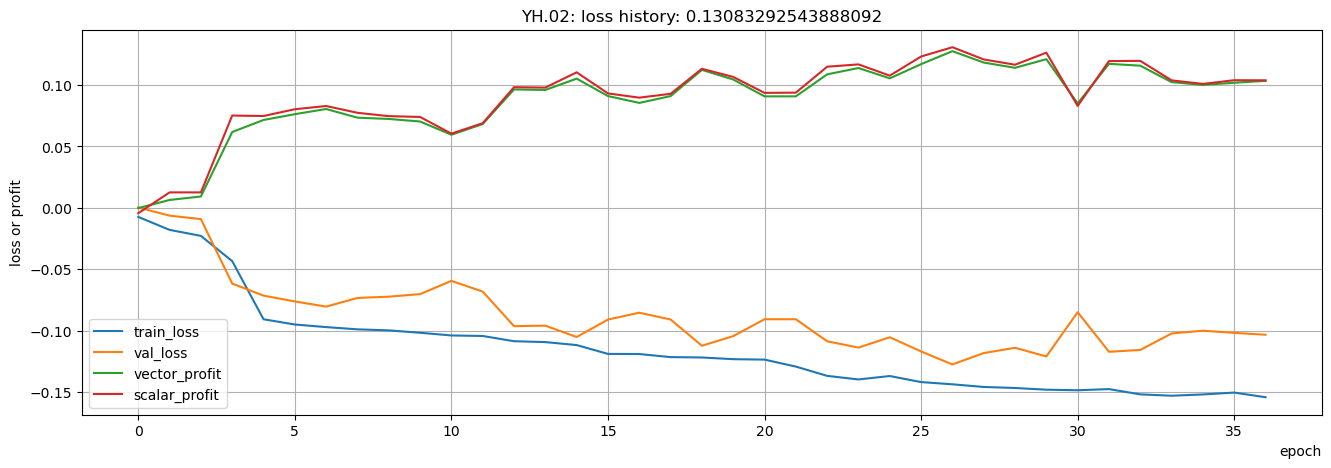

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
history.show(ax, show_val_0=GET_VAL_LOSS_0)

In [44]:
model_1x2 = create_model_object(Model_1X2)

In [45]:
#-------------------------------------------------------------------------------------------------
try:    model_1x2.load_weights(checkpointPath)
except: pass
epoch = 0   # no gauge, as it's not an argument but measured in conclude_train_epoch.
for train_loss, val_loss_0, val_profit_0, val_loss, val_profit, learning_rate, recall, precision, time_taken in history.get_zipped_history():
    _ = conclude_train_epoch(epoch, model_1x2, history, checkpointPath, checkpointPathBest, train_loss, val_loss_0, val_profit_0, val_loss, val_profit, learning_rate, recall, precision, time_taken, playback = True, gaugeTerm='val_profit')
    epoch += 1

epoch: 0, train_loss: -0.00743, val_loss_0: 0.00000, val_profit_0: 0.00000, val_loss: 0.00024, val_profit: -0.00439, learning_rate: 5.00000e-07, recall/precision: -1.0000/-1.0000, time_taken: 18.0 m
---------
epoch: 1, train_loss: -0.01797, val_loss_0: 0.00000, val_profit_0: 0.00000, val_loss: -0.00640, val_profit: 0.01256, learning_rate: 4.96546e-07, recall/precision: -1.0000/-1.0000, time_taken: 17.7 m
---------
epoch: 2, train_loss: -0.02287, val_loss_0: 0.00000, val_profit_0: 0.00000, val_loss: -0.00921, val_profit: 0.01256, learning_rate: 4.93116e-07, recall/precision: -1.0000/-1.0000, time_taken: 17.7 m
epoch: 3, train_loss: -0.04344, val_loss_0: 0.00000, val_profit_0: 0.00000, val_loss: -0.06174, val_profit: 0.07516, learning_rate: 4.89710e-07, recall/precision: -1.0000/-1.0000, time_taken: 17.4 m
---------
epoch: 4, train_loss: -0.09081, val_loss_0: 0.00000, val_profit_0: 0.00000, val_loss: -0.07155, val_profit: 0.07479, learning_rate: 4.86327e-07, recall/precision: -1.0000/-1.

In [46]:
# @tf.function  #-------------------- Weird: no work.
def train(epochs, nUpgrades, model, optimizer, history, checkpointPath, checkpointPathBest, train_ds, valid_batches, apply_train_pipeline, get_f1=False, gaugeTerm='val_loss', get_val_loss_0=False):
    epochs = epochs; seen_upgrades = 0
    for epoch in range(history.len(), history.len() + epochs):
        start_time = time.time()
        optimizer.step.assign(history.len()); learning_rate = optimizer.lr.numpy()
        prev_nSum = new_nSum = 0; prev_mSum = new_mSum = 0; epoch_loss = 0.; sub_loss = 0.
        samples_seen = 0 # sub_loss = tf.Variable(0.0, dtype=tf.float32, trainable=False)
        set_seed(epoch)
        train_batches = apply_train_pipeline(train_ds)      # This is REQUIRED to reshuffle the data at each iteration. Tested.
        for batch_id, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(train_batches):    # reshuffle at each iteration - NO!
            x = (sequence, base_bb, baseDateDetails, mask); y = value
            samples_seen += sequence.shape[0]
            loss_sum = train_step(model, optimizer, x, y)  # ()

            batch_size = baseId.shape[0]
            new_nSum += batch_size; new_mSum += batch_size
            sub_loss = sub_loss * prev_nSum / new_nSum + loss_sum / new_nSum
            epoch_loss = epoch_loss * prev_mSum / new_mSum + loss_sum / new_mSum
            prev_nSum = new_nSum; prev_mSum = new_mSum

            if batch_id % int(500/BATCH_SIZE) == 0:
                # optimizer.step.assign(history.len()); learning_rate = optimizer.lr.numpy()  #----------------------------------------------------
                show_sub_epoch(epoch, batch_id, sub_loss, epoch_loss, samples_seen, learning_rate); prev_nSum = new_nSum = 0; sub_loss = 0.0

        show_sub_epoch(epoch, batch_id, sub_loss, epoch_loss, samples_seen, learning_rate)  # closing show
        val_loss_0 = val_profit_0 = 0.0
        if get_val_loss_0: val_loss_0, val_profit_0, _ = find_loss_for_dataset(model, train_batches)
        val_loss, val_profit, _ = find_loss_for_dataset(model, valid_batches)

        recall = precision = -1.0
        if get_f1: recall, precision = find_recall_precision(model, valid_batches); recall = recall.numpy(); precision = precision.numpy()
        
        # epoch, model, history, checkpointPath, checkpointPathBest, epoch_loss, val_loss, learning_rate, recall, precision, time_taken, playback=False
        upgraded = conclude_train_epoch(epoch, model, history, checkpointPath, checkpointPathBest, float(epoch_loss), float(val_loss_0), float(val_profit_0), float(val_loss), float(val_profit), learning_rate, recall, precision, (time.time()-start_time)/60, playback=False, gaugeTerm=gaugeTerm)
        if upgraded: seen_upgrades += 1
        if seen_upgrades >= nUpgrades: break

    return seen_upgrades


In [47]:
if OPERATION == 'PRETRAIN': # model_1x2 is trained to find profitable staking vectors for games, although average profitability is far below zero.
    try:    model_1x2.load_weights(checkpointPath).expect_partial(); print("model_1x2 loaded its previous checkpoint.")
    except: print("model_1x2 loaded its initial weights.")    # The raw model_1x2 itself is the starting point.
    optimizer = Adam_exponential(history.len(), STARTING_LEARNING_RATE, EXAMPLE_LEARNING_STEP, EXAMPLE_LEARNING_RATE, beta_1=0.9, beta_2=0.99, epsilon=1e-12)
    # Goal: get checkpointPathBest checkpoint, which is used as the starting checkpoint of both TRAIN_C and FINETUNE.
    nEpochs = 300; wanted_upgrades = 60
    # epochs, nUpgrades, model, optimizer, history, checkpointPath, checkpointPathBest, train_ds, valid_batches, apply_train_pipeline, get_f1=False
    nUpgrades = train(nEpochs, wanted_upgrades, model_1x2, optimizer, history, checkpointPath, checkpointPathBest, train_ds, valid_batches, apply_train_pipeline, get_f1 = False, gaugeTerm='val_profit', get_val_loss_0=GET_VAL_LOSS_0)
    
    OPERATION = 'TRAIN_C'   # Certificate for the next operation

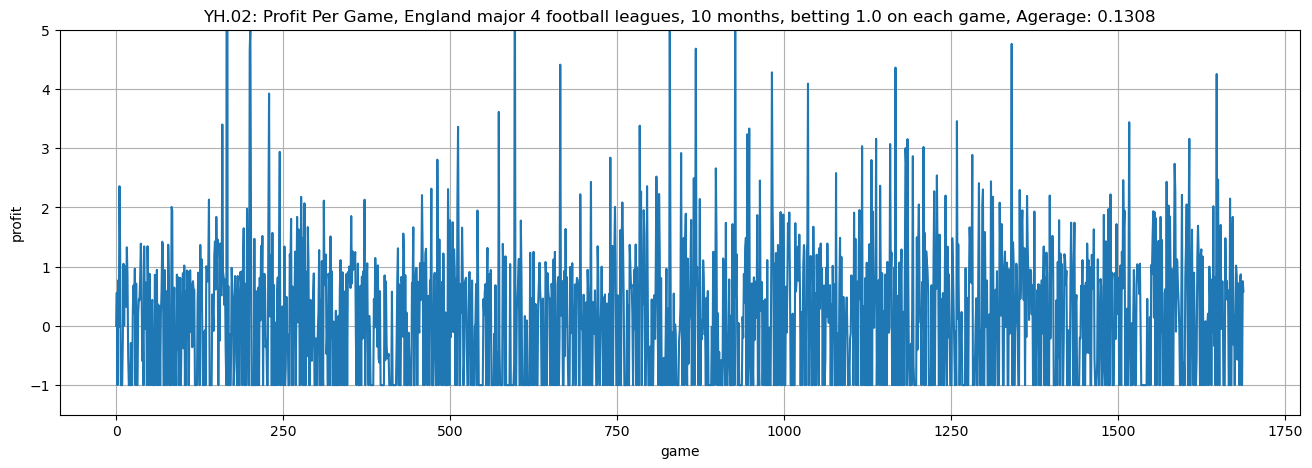

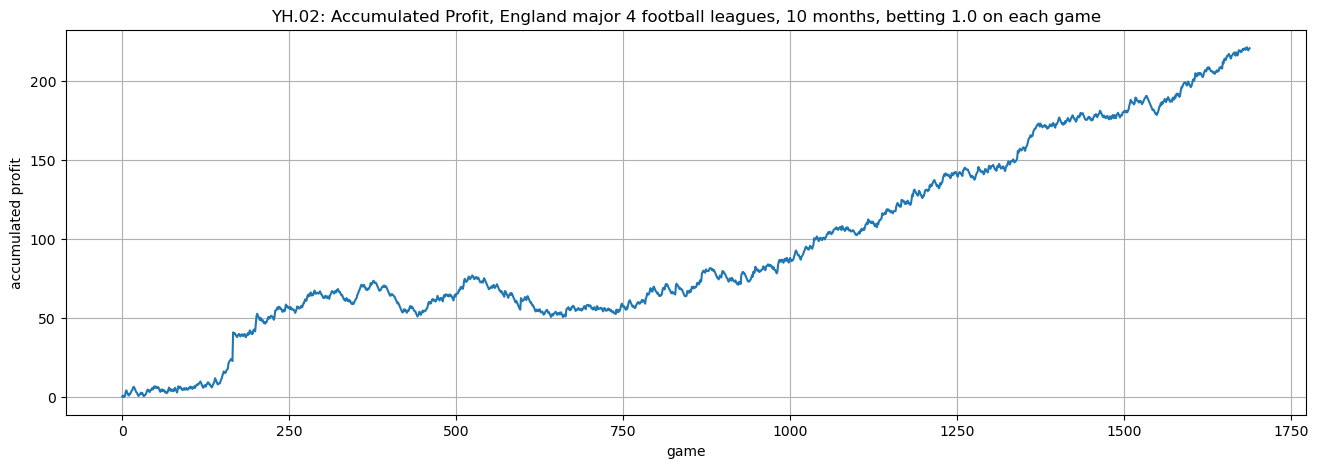

In [48]:
if OPERATION == 'BACKTEST':
    model_1x2.load_weights(checkpointPathBest)
    avg_loss, avg_profit, profits = find_loss_for_dataset(model_1x2, valid_batches)
    profits = list(profits.numpy())
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
    plt.plot(profits); plt.ylim([-1.5, 5])
    plt.grid(True)
    plt.title(TEST_ID + ": Profit Per Game, " + COUNTRY + " major 4 football leagues, 10 months, betting 1.0 on each game, Agerage: {:.4f}".format(sum(profits)/len(profits)))
    plt.xlabel('game'); plt.ylabel('profit')
    plt.show()

    valid_acc = []; acc = 0.0
    for i in range(len(profits)):
        acc += profits[i]
        valid_acc.append(acc)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
    plt.plot(valid_acc)
    plt.grid(True)
    plt.title(TEST_ID + ": Accumulated Profit, " + COUNTRY + " major 4 football leagues, 10 months, betting 1.0 on each game")
    plt.xlabel('game'); plt.ylabel('accumulated profit')
    plt.show()

74.20643543164888 75.20516000819703


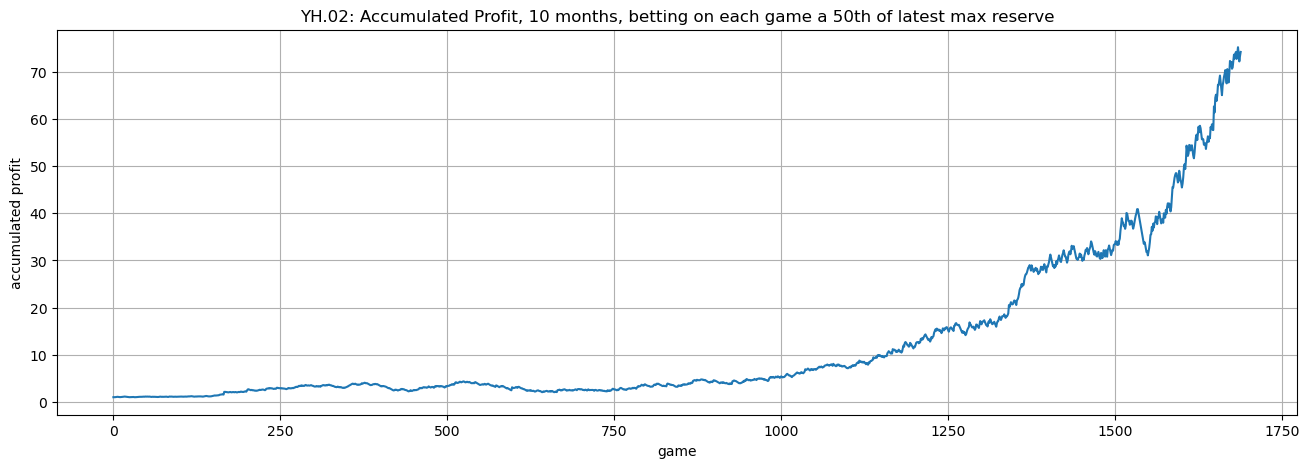

In [49]:
profits = profits
safety = 50
reserve = 1.0; max_reserve = reserve; reserve_history = []; win = 0.0
for p in profits:
    win = p * max_reserve / safety
    # win = p * reserve / safety
    reserve += win
    reserve_history.append(reserve)
    if max_reserve <= reserve: max_reserve = reserve
    if reserve <= 0.0:
        print("nagetive reserve!"); break
print(reserve, max_reserve)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
plt.plot(reserve_history)
plt.grid(True)
plt.title(TEST_ID + ": Accumulated Profit, 10 months, betting on each game a " + str(safety) + "th of latest max reserve")
plt.xlabel('game'); plt.ylabel('accumulated profit')
plt.show()   



In [50]:
#================== create an empty excel sheet to edit bb_to_predict into.
if not TRAIN_MODE:
    import pandas as pd

    Odds_cols = []
    for b in range(5):
        Odds_cols += ['HDA'+str(b)+'H', 'HDA'+str(b)+'D', 'HDA'+str(b)+'A']


    columns = {'no': pd.Series(dtype='int'), 'year': pd.Series(dtype='int'), 'month': pd.Series(dtype='int'), 'day': pd.Series(dtype='int'),
        'Div': pd.Series(dtype='str'), 'HomeTeam': pd.Series(dtype='str'), 'AwayTeam': pd.Series(dtype='str')}
    columns = columns | {col: pd.Series(dtype='float') for col in Odds_cols}
    df = pd.DataFrame(columns)

    df.to_excel(os.path.join(".", "history", "test.xlsx"), sheet_name="my sheet")

In [51]:
if not TRAIN_MODE:      # just sketch
    # df_bbab_not_in_train : { BBAB(game) | BBAB(game) was not in the training set }
    # Columns required for fixture_id_to_ids_uk_v3: ['id', 'Div', 'HomeTeam', 'AwayTeam', 'Date']
    # 'id' can be chosen temporarily arbitrally outside of existing ids.
    df_bbab_to_predict = create_bbab_to_predict(special_path) # { BBAB(game) | game has to be predicted. AB part is fake. }

In [52]:
import pandas as pd

if not TRAIN_MODE:      # just sketch
    YH_assistant.assign_seasonal_filenames(gameHistory_folder_path)
    df_train, df_bbab_not_in_train = YH_assistant.get_train_and_new_from_football_data_v2(gameHistory_folder_path, countryTheme_folder_path, Required_Non_Odds_cols, NUMBER_BOOKIES, oddsGroupsToExclude = BOOKIE_TO_EXCLUDE, preferedOrder = PREFERED_ORDER, train_mode = TRAIN_MODE, skip=True)
    print("df_train: ", df_train.shape)
    print("df_bbab_not_in_train: ", df_bbab_not_in_train.shape)

    df_sequence = pd.concat([df_train, df_bbab_not_in_train])   # No duplicates. Maximized bbab dataframe.
    df_base = df_bbab_to_predict                                  # Minimized
    # Do NOT save, because the 'id' column for df_bb_to_predict is temporary and arbitrary.
    predict_map = YH_assistant.create_map_v1(map_folder_path, map_filename_base, targetLength, df_sequence, df_base, year_span=SEQ_YEAR_SPAN, testcount=-1, to_save=False)

    df_sequence = pd.concat([df_train, df_bbab_not_in_train])   # No duplicates. Maximized bbab dataframe.
    df_base = df_bbab_to_predict
    existing_ds = None
    total_map = predict_map                                     # Minimized
    # Let the function use a dummy Y, as df_base has not Y's.
    predict_ds = create_dataset(df_sequence, df_base, existing_ds, total_map, tokenizer_team, normalization_parms)

    stake_p = model_1X2(predict_ds)   # vector stake
